In [1]:
from IPython.core.display import display, HTML, clear_output
display(HTML("<style>.container { width:100% !important; }</style>"))
from pathlib import Path

import pandas as pd
import numpy as np

import scipy
from scipy import optimize, integrate
from scipy import interpolate

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib import container
import matplotlib.ticker as ticker
from matplotlib.ticker import NullFormatter
from matplotlib.ticker import LinearLocator, FormatStrFormatter

import time
import math
import random
import multiprocessing as mp
import os
import subprocess
from shutil import copyfile

%load_ext autoreload
%autoreload 2

from modules_ns_bim_spherical.geometry import *
from modules_ns_bim_spherical.hybrid_model_oc_v1 import *
from modules_ns_bim_spherical.numerical_Derjaguin_v1 import *
from modules_ns_bim_spherical.oc_plots_v1 import *
from modules_ns_bim_spherical.orthogonal_collocation_v1 import *
from modules_ns_bim_spherical.v2_ns_bim_helper_plus import *

from modules_ns_bim_spherical import monomer_spheres as mono_s
import modules_ns_bim_spherical.monte_carlo_functions as mc


### Resin data

In [2]:
surf_dens_seph = 3.413e-6 # [mol m-2]
surf_dens_caq  = 3.016e-6
surf_dens_phq  = 2.55e-6
surf_dens_pxq  = 3.72e-6

sigma_seph = -1.0 * surf_dens_seph * constants().F # [C m-2]
sigma_caq  = surf_dens_caq * constants().F
sigma_phq  = surf_dens_phq * constants().F
sigma_pxq  = surf_dens_pxq * constants().F

print(sigma_seph, sigma_caq, sigma_phq, sigma_pxq)

-0.329303305 0.29099876 0.24603675000000003 0.35892419999999997


In [3]:
ns_bim_dir      = 'ns_bim_programs/'
protein_folders = ['adh_pH_7', 'blg_pH_7', 'cat_pH_7']
ion_str_list    = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5]

In [4]:
def get_monomer_centers(name):
    if name[:3] == 'adh':
        a = [87.028, -15.171, 49.232]
        b = [56.070,  13.563,  48.900]
        c = [87.028,  15.171,  78.922]
        d = [56.070, -13.563,  79.254]
        return [a, b, c, d]
    elif name[:3] == 'blg':
        a = [-11.793,  14.230,  -8.368]
        b = [-4.800,   1.549,  19.681]
        return [a, b]
    elif name[:3] == 'cat':
        a = [36.836,  38.691,  25.609]
        b = [22.759,  41.244,  62.917]
        c = [21.575,   7.333,  56.942]
        d = [6.625,  22.370,  23.069]
        return [a, b, c, d]
    elif name == 'mab_D':
        a = [8.996, -10.816, -65.429]
        b = [5.088, -1.168, -1.494]
        c = [10.858,-53.506,-32.908]
        return [a, b, c]
    else:
        print('Problem determining monomer radius')
        
def get_angle(x1, y1, z1, x2, y2, z2, x3, y3, z3):
    ax = x1 - x3
    ay = y1 - y3
    az = z1 - z3
    bx = x2 - x3
    by = y2 - y3
    bz = z2 - z3
    
    norm_a = np.sqrt(ax**2 + ay**2 + az**2)
    norm_b = np.sqrt(bx**2 + by**2 + bz**2)
    return np.arccos((ax*bx + ay*by + az*bz)/(norm_a*norm_b))
    

In [5]:
n = 5000

if n >= 600000:
    epsilon = 214
elif n>= 400000:
    epsilon = 75
elif n>= 11000:
    epsilon = 27
elif n>= 890:
    epsilon = 10
elif n>= 177:
    epsilon = 3.33
elif n>= 24:
    epsilon = 1.33
else:
    epsilon = 0.33

goldenRatio = (1 + 5**0.5)/2
i = np.arange(0, n) 
phi = 2 * np.pi * i / goldenRatio
theta = np.arccos(1 - 2*(i+epsilon)/(n-1+2*epsilon))

In [6]:
def get_monomer_radius(name):
    if name[:3] == 'adh':
        return 20.35 # [A]
    elif name[:3] == 'blg':
        return 15.78
    elif name[:3] == 'cat':
        return 17.21
    else:
        print('Problem determining monomer radius')

def get_ion_str_from_protein_name(protein):
    ind_slice = protein.rfind('_') + 1
    return int(protein[ind_slice:])/1000


### Run NS-BIM at the specified equivalent sphere volumes and ionic strengths

In [4]:
for ion_str in ion_str_list:
    for ind, protein in enumerate(protein_folders): 
        prot_dir     = 'ns_bim_monomer_spheres/ns_bim_programs/' + protein + '/'
        new_folder   = 'ns_bim_monomer_spheres/results/ns_bim_data/' + protein + '_' +\
                       str(int(ion_str*1.0e3)) + '/'
        meta_run_ns_bim_v2(prot_dir, ion_str, new_folder)

Creation of the directory ns_bim_monomer_spheres/results/ns_bim_data/adh_pH_7_50/ failed
Creation of the directory ns_bim_monomer_spheres/results/ns_bim_data/blg_pH_7_50/ failed
Creation of the directory ns_bim_monomer_spheres/results/ns_bim_data/cat_pH_7_50/ failed
Creation of the directory ns_bim_monomer_spheres/results/ns_bim_data/adh_pH_7_100/ failed
Creation of the directory ns_bim_monomer_spheres/results/ns_bim_data/blg_pH_7_100/ failed
Creation of the directory ns_bim_monomer_spheres/results/ns_bim_data/cat_pH_7_100/ failed
Creation of the directory ns_bim_monomer_spheres/results/ns_bim_data/adh_pH_7_200/ failed
Creation of the directory ns_bim_monomer_spheres/results/ns_bim_data/blg_pH_7_200/ failed
Creation of the directory ns_bim_monomer_spheres/results/ns_bim_data/cat_pH_7_200/ failed
Creation of the directory ns_bim_monomer_spheres/results/ns_bim_data/adh_pH_7_300/ failed
Creation of the directory ns_bim_monomer_spheres/results/ns_bim_data/blg_pH_7_300/ failed
Creation of t

## List protein data

In [4]:
nsbim_data_dir = 'ns_bim_monomer_spheres/results/ns_bim_data/'

protein_folders = os.listdir(nsbim_data_dir)
protein_folders.sort()
protein_folders

# # For catalase calculations
# protein_folders = protein_folders[-6:]
# protein_folders


['adh_pH_7_100',
 'adh_pH_7_200',
 'adh_pH_7_300',
 'adh_pH_7_400',
 'adh_pH_7_50',
 'adh_pH_7_500',
 'adh_pH_7_ref_sep_100',
 'adh_pH_7_ref_sep_200',
 'adh_pH_7_ref_sep_300',
 'adh_pH_7_ref_sep_400',
 'adh_pH_7_ref_sep_50',
 'adh_pH_7_ref_sep_500',
 'blg_pH_7_100',
 'blg_pH_7_200',
 'blg_pH_7_300',
 'blg_pH_7_400',
 'blg_pH_7_50',
 'blg_pH_7_500',
 'cat_pH_7_100',
 'cat_pH_7_200',
 'cat_pH_7_300',
 'cat_pH_7_400',
 'cat_pH_7_50',
 'cat_pH_7_500']

-1.8036503220033335 1.7602122765533335


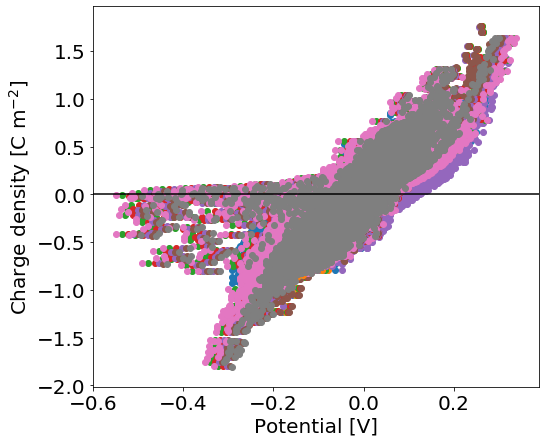

In [8]:
fig, ax = plt.subplots()
fig.set_size_inches(8, 7, forward=True)
font = {'weight' : 'normal',
        'size'   : 20}
plt.rc('font', **font)
ax.set_xlabel('Potential [V]')
ax.set_ylabel(r'Charge density [C m$^{-2}$]')
# ax.set_ylim(-0.002, 0.002)
ax.axhline(color='black')

mins = []
maxs = []

for name in protein_folders:
    prot_dir   = nsbim_data_dir + name
    protein    = mono_s.protein_class(name)
    protein.df = mono_s.get_df_elem(prot_dir)
    ax.scatter(protein.df['phi_V'], protein.df['charge_C_m2'])
    
    mins.append(min(protein.df['charge_C_m2']))
    maxs.append(max(protein.df['charge_C_m2']))

global_min = min(mins)
global_max = max(maxs)

print(global_min, global_max)

fig.savefig('ns_bim_monomer_spheres/results/images/correlation_potential_charge.png', 
            bbox_inches='tight', dpi = 300)

adh_pH_7_500
blg_pH_7_500
cat_pH_7_500


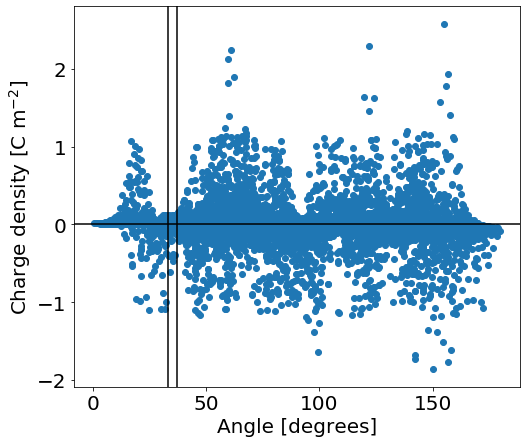

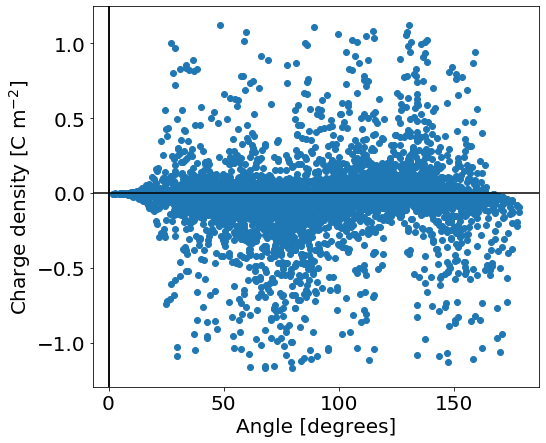

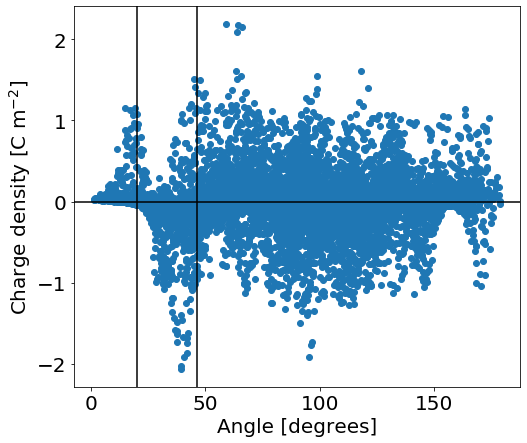

In [120]:
for i in range(3):
    name = protein_folders[i*6 + 5]
    print(name)

    prot_dir = nsbim_data_dir + name
    df_nodes = mono_s.get_nodes(prot_dir)
    centers  = get_monomer_centers(name)
    n_mers   = len(centers)
    n_mono_nodes = int(len(df_nodes)/n_mers)

    x_sum, y_sum, z_sum = 0, 0, 0
    for i in centers:
        x_sum += i[0]
        y_sum += i[1]
        z_sum += i[2]
    unit_center = [x_sum/n_mers, y_sum/n_mers, z_sum/n_mers]

    closest_angles_rad = []
    for ind, c in enumerate(centers):
        for j in centers[ind+1:]:
            closest_angles_rad.append(get_angle(j[0], j[1], j[2], unit_center[0], 
                                                unit_center[1], unit_center[2], c[0], c[1], 
                                                c[2]))
    closest_angles_deg = np.array(closest_angles_rad)*180/np.pi
    min_close_angle = min(closest_angles_deg)
    max_close_angle = max(closest_angles_deg)

    for ind, content in df_nodes.iterrows():
        monomer = int(ind/n_mono_nodes)
        df_nodes.at[ind, 'mono_cent_x_A'] = centers[monomer][0]
        df_nodes.at[ind, 'mono_cent_y_A'] = centers[monomer][1]
        df_nodes.at[ind, 'mono_cent_z_A'] = centers[monomer][2]

    df_nodes['unit_center_x_A'] = unit_center[0]
    df_nodes['unit_center_y_A'] = unit_center[1]
    df_nodes['unit_center_z_A'] = unit_center[2]

    df_nodes['angle_rad'] = get_angle(df_nodes['x_A'], df_nodes['y_A'], df_nodes['z_A'],
                                      df_nodes['unit_center_x_A'], 
                                      df_nodes['unit_center_y_A'],
                                      df_nodes['unit_center_z_A'],
                                      df_nodes['mono_cent_x_A'],
                                      df_nodes['mono_cent_y_A'],
                                      df_nodes['mono_cent_z_A'])
    df_nodes['angle_deg'] = df_nodes['angle_rad']*180/np.pi

    fig, ax = plt.subplots()
    fig.set_size_inches(8, 7, forward=True)
    font = {'weight' : 'normal',
            'size'   : 20}
    plt.rc('font', **font)
    ax.set_xlabel('Angle [degrees]')
    ax.set_ylabel(r'Charge density [C m$^{-2}$]')

    ax.scatter(df_nodes['angle_deg'], df_nodes['charge_C_m2'])
    ax.axvline(min_close_angle, color='k')
    ax.axvline(max_close_angle, color='k')
    ax.axhline(color='k')
    image_name = 'charge_density_vs_angle_' + name + '.png'
    plt.savefig('ns_bim_monomer_spheres/results/images/' + image_name, dpi=300, 
                bbox_inches='tight')

In [130]:
protein_folders = ['adh_pH_7_ref_sep']
for ion_str in ion_str_list:
    for ind, protein in enumerate(protein_folders): 
        prot_dir     = 'ns_bim_monomer_spheres/ns_bim_programs/' + protein + '/'
        new_folder   = 'ns_bim_monomer_spheres/results/ns_bim_data/' + protein + '_' +\
                       str(int(ion_str*1.0e3)) + '/'
        meta_run_ns_bim_v2(prot_dir, ion_str, new_folder)

Creation of the directory ns_bim_monomer_spheres/results/ns_bim_data/adh_pH_7_ref_sep_50/ failed
Creation of the directory ns_bim_monomer_spheres/results/ns_bim_data/adh_pH_7_ref_sep_100/ failed
Creation of the directory ns_bim_monomer_spheres/results/ns_bim_data/adh_pH_7_ref_sep_200/ failed
Creation of the directory ns_bim_monomer_spheres/results/ns_bim_data/adh_pH_7_ref_sep_300/ failed
Creation of the directory ns_bim_monomer_spheres/results/ns_bim_data/adh_pH_7_ref_sep_400/ failed
Creation of the directory ns_bim_monomer_spheres/results/ns_bim_data/adh_pH_7_ref_sep_500/ failed


-1.3629483965470002 1.75703396073
-1.3636056163006665 1.7573290301966666


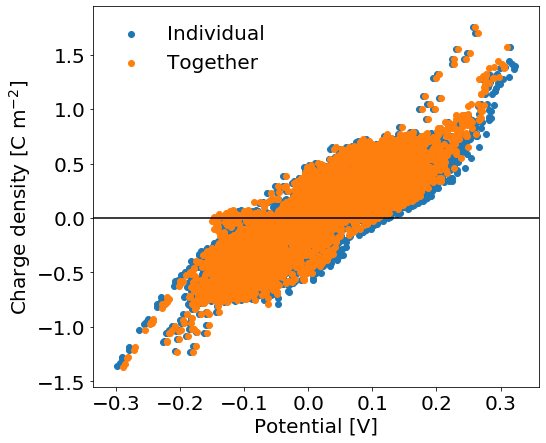

In [129]:
protein_folders = ['adh_pH_7_ref_sep_100', 'adh_pH_7_100']

fig, ax = plt.subplots()
fig.set_size_inches(8, 7, forward=True)
font = {'weight' : 'normal',
        'size'   : 20}
plt.rc('font', **font)
ax.set_xlabel('Potential [V]')
ax.set_ylabel(r'Charge density [C m$^{-2}$]')
# ax.set_ylim(-0.002, 0.002)
ax.axhline(color='black')

mins = []
maxs = []

for name in protein_folders:
    prot_dir   = nsbim_data_dir + name
    protein    = mono_s.protein_class(name)
    protein.df = mono_s.get_df_elem(prot_dir)
    
    if name == protein_folders[0]:
        legend = 'Individual'
    else:
        legend = 'Together'
    ax.scatter(protein.df['phi_V'], protein.df['charge_C_m2'], label=legend)

    mins.append(min(protein.df['charge_C_m2']))
    maxs.append(max(protein.df['charge_C_m2']))

    global_min = min(mins)
    global_max = max(maxs)

    print(global_min, global_max)

ax.legend(loc='best', frameon=False)
fig.savefig('ns_bim_monomer_spheres/results/images/correlation_potential_charge_adh_100_ref_sep.png', 
            bbox_inches='tight', dpi = 300)

## Constant potential BC

In [8]:
integrand_dir  = 'ns_bim_monomer_spheres/results/integrand_results/'
energy_dir     = 'ns_bim_monomer_spheres/results/energy_results/'

resin_list = ['caq', 'phq', 'pxq']

for resin in resin_list:
    for name in protein_folders:
        
        ion_str = get_ion_str_from_protein_name(name)
        radius  = get_monomer_radius(name)

        prot_dir   = nsbim_data_dir + name
        start_time = time.time()
        sol        = bulk_solution(ion_str)
        protein    = mono_s.protein_class(name)
        protein.df = mono_s.get_df_elem(prot_dir)

        kap_h_min   = 0.1
        kap_h_mid   = 1.2
        kap_h_max   = 9.0
        z_min       = kap_h_min/sol.kappa # [m]
        z_mid       = kap_h_mid/sol.kappa
        z_max       = kap_h_max/sol.kappa
        zs = np.concatenate((np.linspace(z_min, z_mid, 30)[:-1], 
                             np.linspace(z_mid, z_max, 21)))

        energy_map_file = 'oc_energy_maps/' + resin + '_' +\
                          str(int(sol.ion_str*1.0e3)) + '_expanded_1.csv'
        energy_fun      = get_interp_fun(energy_map_file)

        args_list = [(protein, i, theta[i], phi[i], zs, energy_fun, sol, radius) for i in range(n)]
        pool      = mp.Pool(processes = mp.cpu_count())
        results   = pool.map(mono_s.get_integrand_list, args_list)
        pool.close()
        pool.join()

        indeces       = [res[0] for res in results]
        integrand_res = [res[1] for res in results]
        energy_res    = [res[2] for res in results]

        new_integrand_df = pd.DataFrame(integrand_res, index=indeces, 
                                        columns=zs)
        new_energy_df    = pd.DataFrame(energy_res, index=indeces, 
                                        columns=zs)

        file = resin + '_' + protein.name + '.csv'
        new_integrand_df.to_csv(integrand_dir + file)
        new_energy_df.to_csv(energy_dir + file)

        print_time((time.time() - start_time)/60.0)
        print('Completed ' + file + ' \n')

0.62
Completed caq_adh_pH_7_100.csv 

0.62
Completed caq_adh_pH_7_200.csv 

0.62
Completed caq_adh_pH_7_300.csv 

0.63
Completed caq_adh_pH_7_400.csv 

0.62
Completed caq_adh_pH_7_50.csv 

0.63
Completed caq_adh_pH_7_500.csv 

0.45
Completed caq_blg_pH_7_100.csv 

0.44
Completed caq_blg_pH_7_200.csv 

0.46
Completed caq_blg_pH_7_300.csv 

0.45
Completed caq_blg_pH_7_400.csv 

0.44
Completed caq_blg_pH_7_50.csv 

0.45
Completed caq_blg_pH_7_500.csv 

0.63
Completed caq_cat_pH_7_100.csv 

0.63
Completed caq_cat_pH_7_200.csv 

0.62
Completed caq_cat_pH_7_300.csv 

0.63
Completed caq_cat_pH_7_400.csv 

0.61
Completed caq_cat_pH_7_50.csv 

0.62
Completed caq_cat_pH_7_500.csv 

0.62
Completed phq_adh_pH_7_100.csv 

0.62
Completed phq_adh_pH_7_200.csv 

0.63
Completed phq_adh_pH_7_300.csv 

0.62
Completed phq_adh_pH_7_400.csv 

0.62
Completed phq_adh_pH_7_50.csv 

0.63
Completed phq_adh_pH_7_500.csv 

0.45
Completed phq_blg_pH_7_100.csv 

0.44
Completed phq_blg_pH_7_200.csv 

0.45
Completed p

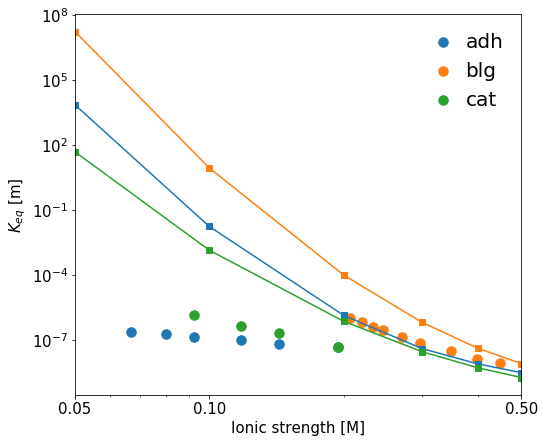

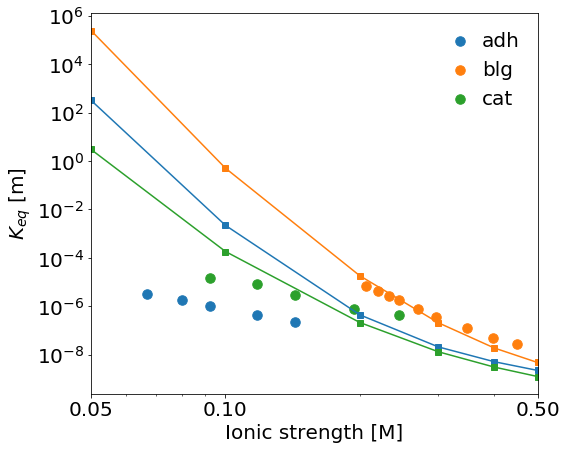

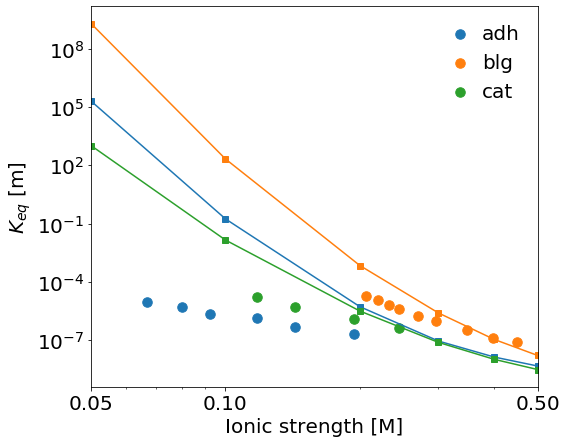

In [11]:
integrand_dir  = 'ns_bim_monomer_spheres/results/integrand_results/'
resin_list     = ['caq', 'phq', 'pxq']

z0 = 3.0e-10 

res = {}
species_pH = {}
for protein in protein_folders:
    species_pH[protein[:protein.rfind('_')]] = 1

for resin in resin_list:
    fig, ax = plt.subplots()
    fig.set_size_inches(8, 7, forward=True)
    font = {'weight' : 'normal',
            'size'   : 20}
    plt.rc('font', **font)
    ax.set_xlabel('Ionic strength [M]')
    ax.set_ylabel(r'$K_{eq}$ [m]')
    ax.set_yscale('log')
    ax.set_xscale('log')
    # # axs.set_ylim(7e-9, 1e-5)
    # ax.set_ylim(7e-9, 1e-4)
    ax.set_xlim(0.05, 0.5)
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.xaxis.set_minor_formatter(NullFormatter())
    ax.set_xticks([0.05, 0.1, 0.5])
    ax.get_xaxis().set_major_formatter(ticker.ScalarFormatter())
    
    for protein in protein_folders:
        if protein[:3] == 'lys':
            pass
        else:
            integrand_df_file = resin + '_' + protein + '.csv'
            Keq = get_model_Keq_v2([ion_str], integrand_df_file, z0, integrand_dir)[0]
            res[protein] = Keq

    for key in species_pH:
        if key[:3] == 'lys':
            pass
        else:
            
            ion_str = []
            Keq = []
            for rkey in res:
                if rkey[:rkey.rfind('_')] == key:
                    ion_str.append(get_ion_str_from_protein_name(rkey))
                    Keq.append(res[rkey])
            order = np.argsort(ion_str)
            xs = np.array(ion_str)[order]
            ys = np.array(Keq)[order]
            ax.plot(xs, ys, 's-')

            df_exp = get_exp_data(key, resin)
            label = key[:3]
            plot_exp_data_v2(ax, df_exp, label)

    fig.savefig('ns_bim_monomer_spheres/results/images/' + resin + '_' +\
                str(int(round(z0*1.0e12))) + '_pm_z0.png', 
                bbox_inches='tight', dpi = 300)

## Saving data for vmd plotting

In [7]:
def save_link_txt(prot_dir, df_link):
    df_link.drop(axis=1, columns=[' element_id'], inplace=True)
    np.savetxt(prot_dir + 'links.txt', df_link.values, fmt='%d')
    return

def save_node_txt(protein, prot_dir, df_node):
    df_node.drop(axis=1, columns=[' node_id', 'x_nm', 'y_nm', 'z_nm', 'phi_mV'], inplace=True)
    df_node = df_node[['phi_V', 'x_A', 'y_A', 'z_A']].copy()
    df_node['rad_A'] = 0.0
    centers = get_monomer_centers(protein)
    
    nodes_per_mono = len(df_node)/len(centers)
    for ind, content in df_node.iterrows():
        center_ind = int(ind/nodes_per_mono)
        [xc, yc, zc] = centers[center_ind]
        df_node.at[ind, 'x_n_A'] = content['x_A'] - xc
        df_node.at[ind, 'y_n_A'] = content['y_A'] - yc
        df_node.at[ind, 'z_n_A'] = content['z_A'] - zc
        n_length = np.sqrt(df_node.at[ind, 'x_n_A']**2 + df_node.at[ind, 'y_n_A']**2 +\
                           df_node.at[ind, 'z_n_A']**2)
        df_node.at[ind, 'x_n_A'] /= n_length
        df_node.at[ind, 'y_n_A'] /= n_length
        df_node.at[ind, 'z_n_A'] /= n_length

    np.savetxt(prot_dir + 'node_data.txt', df_node.values, fmt='%f')
    return

# for protein in protein_folders:
#     prot_dir = nsbim_data_dir + protein + '/'

#     df_link = mono_s.get_link(prot_dir)
#     df_node = mono_s.get_nodes(prot_dir)

#     save_link_txt(prot_dir, df_link)
#     save_node_txt(protein, prot_dir, df_node)


## Plot charge locations and surface potential histograms
Verify charges belong to the appropriate monomer

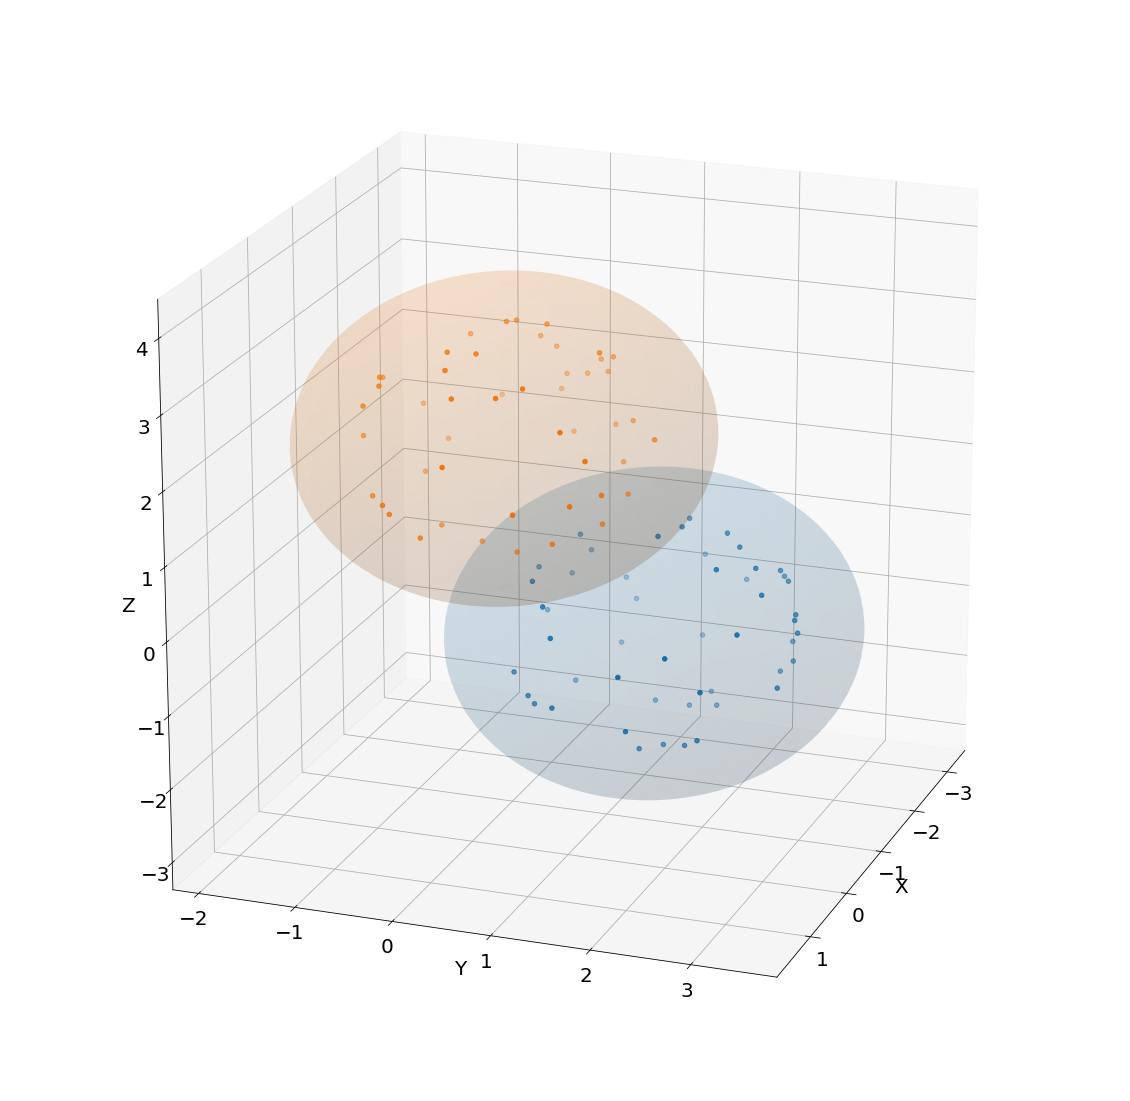

In [137]:
df_charges = pd.read_csv('ns_bim_monomer_spheres/ns_bim_programs/blg_pH_7/Input_Source.csv',
                            names=['id', 'x', 'y', 'z', 'q'])

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# ax.scatter(df_charges['x'][:94], df_charges['y'][:94], df_charges['z'][:94])
# ax.scatter(df_charges['x'][94:187], df_charges['y'][94:187], df_charges['z'][94:187])
# ax.scatter(df_charges['x'][187:281], df_charges['y'][187:281], df_charges['z'][187:281])
# ax.scatter(df_charges['x'][281:], df_charges['y'][281:], df_charges['z'][281:])

# ax.scatter(df_charges['x'][:160], df_charges['y'][:160], df_charges['z'][:160])
# ax.scatter(df_charges['x'][160:319], df_charges['y'][160:319], df_charges['z'][160:319])
# ax.scatter(df_charges['x'][319:478], df_charges['y'][319:478], df_charges['z'][319:478])
# ax.scatter(df_charges['x'][478:], df_charges['y'][478:], df_charges['z'][478:])

ax.scatter(df_charges['x'][:50], df_charges['y'][:50], df_charges['z'][:50])
ax.scatter(df_charges['x'][50:], df_charges['y'][50:], df_charges['z'][50:])


# Plot the sphere
radius = 2.035
u = np.linspace(0, 2 * np.pi, 100)
v = np.linspace(0, np.pi, 100)
centers = get_monomer_centers(protein_folders[6])
for c in centers:
    x = radius * np.outer(np.cos(u), np.sin(v)) + c[0]/10
    y = radius * np.outer(np.sin(u), np.sin(v)) + c[1]/10
    z = radius * np.outer(np.ones(np.size(u)), np.cos(v)) + c[2]/10
    ax.plot_surface(x, y, z, alpha=0.1)

label_size = 20
ax.set_xlabel('X', size=label_size)
ax.set_ylabel('Y', size=label_size)
ax.set_zlabel('Z', size=label_size)
fig.set_size_inches(20, 20, forward=True)
ax.view_init(20, 20)
plt.savefig('ns_bim_monomer_spheres/results/images/blg_charges.png', dpi=300, 
            bbox_inches='tight')

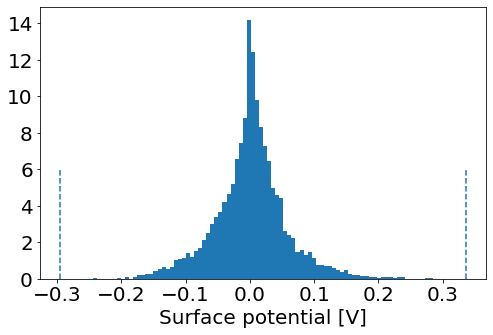

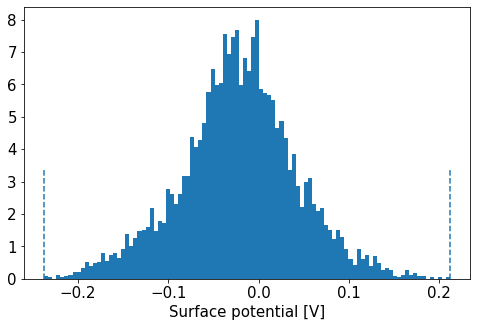

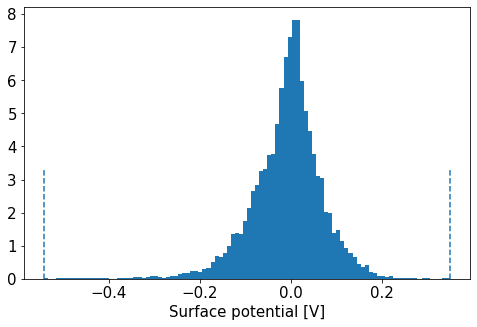

In [10]:
ind_list = [3, 9, 15]

for ind in ind_list:
    protein = protein_folders[ind]
    prot_dir = nsbim_data_dir + protein + '/'
    df_node = mono_s.get_nodes(prot_dir)
    
    fig, ax = plt.subplots()
    font = {'weight': 'normal', 'size': 15}
    plt.rc('font', **font)
    fig.set_size_inches(8, 5, forward=True)
    ax.set_xlabel('Surface potential [V]')
    
    num_bins = 100
    n_1, bins_1, rects_1 = ax.hist(df_node['phi_V'], num_bins, density=True)
    
    y_min_vline = 0
    y_max_vline = 0.4
    ax.axvline(min(df_node['phi_V']), y_min_vline, y_max_vline, ls='--')
    ax.axvline(max(df_node['phi_V']), y_min_vline, y_max_vline, ls='--')
    plt.savefig('ns_bim_monomer_spheres/results/images/' + protein + '.png', dpi=300, 
            bbox_inches='tight')

## CC BC

In [8]:
integrand_dir  = 'ns_bim_monomer_spheres/results_cc/integrand_results/'
energy_dir     = 'ns_bim_monomer_spheres/results_cc/energy_results/'

resin_list = ['caq', 'phq', 'pxq']

for resin in resin_list:
    for name in protein_folders:
        
        ion_str = get_ion_str_from_protein_name(name)
        radius  = get_monomer_radius(name)

        prot_dir   = nsbim_data_dir + name
        start_time = time.time()
        sol        = bulk_solution(ion_str)
        protein    = mono_s.protein_class(name)
        protein.df = mono_s.get_df_elem(prot_dir)

        kap_h_min   = 0.1
        kap_h_mid   = 1.2
        kap_h_max   = 9.0
        z_min       = kap_h_min/sol.kappa # [m]
        z_mid       = kap_h_mid/sol.kappa
        z_max       = kap_h_max/sol.kappa
        zs = np.concatenate((np.linspace(z_min, z_mid, 30)[:-1], 
                             np.linspace(z_mid, z_max, 21)))

        energy_map_file = 'oc_energy_maps_cc/' + resin + '_' +\
                          str(int(sol.ion_str*1.0e3)) + '_total_1.csv'
        energy_fun      = get_interp_fun(energy_map_file)

        args_list = [(protein, i, theta[i], phi[i], zs, energy_fun, sol, radius) for i in range(n)]
        pool      = mp.Pool(processes = mp.cpu_count())
        results   = pool.map(mono_s.get_integrand_list_cc, args_list)
        pool.close()
        pool.join()

        indeces       = [res[0] for res in results]
        integrand_res = [res[1] for res in results]
        energy_res    = [res[2] for res in results]

        new_integrand_df = pd.DataFrame(integrand_res, index=indeces, 
                                        columns=zs)
        new_energy_df    = pd.DataFrame(energy_res, index=indeces, 
                                        columns=zs)

        file = resin + '_' + protein.name + '.csv'
        new_integrand_df.to_csv(integrand_dir + file)
        new_energy_df.to_csv(energy_dir + file)

        print_time((time.time() - start_time)/60.0)
        print('Completed ' + file + ' \n')

0.66
Completed caq_adh_pH_7_100.csv 

0.67
Completed caq_adh_pH_7_200.csv 

0.66
Completed caq_adh_pH_7_300.csv 

0.67
Completed caq_adh_pH_7_400.csv 

0.66
Completed caq_adh_pH_7_50.csv 

0.67
Completed caq_adh_pH_7_500.csv 

0.47
Completed caq_blg_pH_7_100.csv 

0.47
Completed caq_blg_pH_7_200.csv 

0.48
Completed caq_blg_pH_7_300.csv 

0.48
Completed caq_blg_pH_7_400.csv 

0.48
Completed caq_blg_pH_7_50.csv 

0.48
Completed caq_blg_pH_7_500.csv 

0.68
Completed caq_cat_pH_7_100.csv 

0.68
Completed caq_cat_pH_7_200.csv 

0.69
Completed caq_cat_pH_7_300.csv 

0.69
Completed caq_cat_pH_7_400.csv 

0.68
Completed caq_cat_pH_7_50.csv 

0.69
Completed caq_cat_pH_7_500.csv 

0.68
Completed phq_adh_pH_7_100.csv 

0.68
Completed phq_adh_pH_7_200.csv 

0.69
Completed phq_adh_pH_7_300.csv 

0.69
Completed phq_adh_pH_7_400.csv 

0.69
Completed phq_adh_pH_7_50.csv 

0.69
Completed phq_adh_pH_7_500.csv 

0.48
Completed phq_blg_pH_7_100.csv 

0.49
Completed phq_blg_pH_7_200.csv 

0.48
Completed p

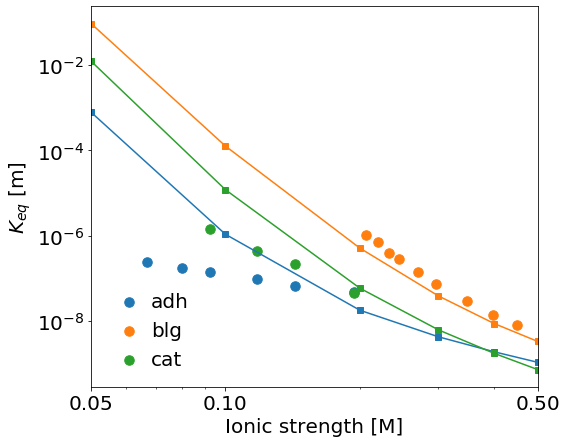

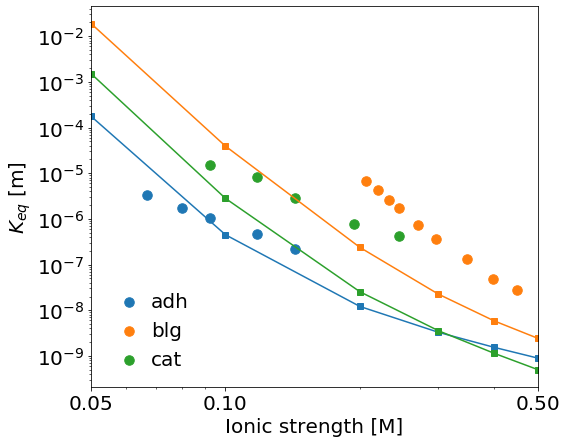

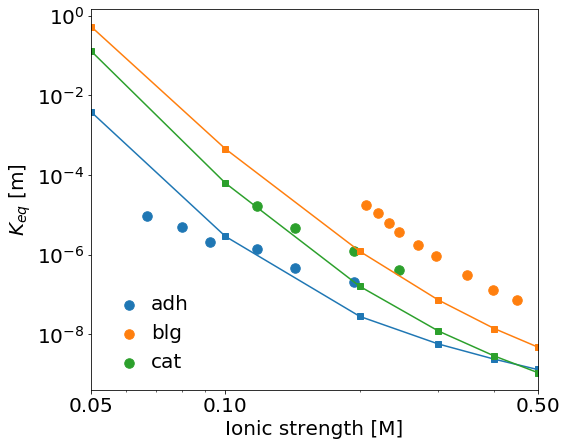

In [10]:
integrand_dir  = 'ns_bim_monomer_spheres/results_cc/integrand_results/'
resin_list     = ['caq', 'phq', 'pxq']

z0 = 3.0e-10 

res = {}
species_pH = {}
for protein in protein_folders:
    species_pH[protein[:protein.rfind('_')]] = 1

for resin in resin_list:
    fig, ax = plt.subplots()
    fig.set_size_inches(8, 7, forward=True)
    font = {'weight' : 'normal',
            'size'   : 20}
    plt.rc('font', **font)
    ax.set_xlabel('Ionic strength [M]')
    ax.set_ylabel(r'$K_{eq}$ [m]')
    ax.set_yscale('log')
    ax.set_xscale('log')
    # # axs.set_ylim(7e-9, 1e-5)
    # ax.set_ylim(7e-9, 1e-4)
    ax.set_xlim(0.05, 0.5)
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.xaxis.set_minor_formatter(NullFormatter())
    ax.set_xticks([0.05, 0.1, 0.5])
    ax.get_xaxis().set_major_formatter(ticker.ScalarFormatter())
    
    for protein in protein_folders:
        if protein[:3] == 'lys':
            pass
        else:
            integrand_df_file = resin + '_' + protein + '.csv'
            Keq = get_model_Keq_v2([ion_str], integrand_df_file, z0, integrand_dir)[0]
            res[protein] = Keq

    for key in species_pH:
        if key[:3] == 'lys':
            pass
        else:
            
            ion_str = []
            Keq = []
            for rkey in res:
                if rkey[:rkey.rfind('_')] == key:
                    ion_str.append(get_ion_str_from_protein_name(rkey))
                    Keq.append(res[rkey])
            order = np.argsort(ion_str)
            xs = np.array(ion_str)[order]
            ys = np.array(Keq)[order]
            ax.plot(xs, ys, 's-')

            df_exp = get_exp_data(key, resin)
            label = key[:3]
            plot_exp_data_v2(ax, df_exp, label)

    fig.savefig('ns_bim_monomer_spheres/results_cc/images/' + resin + '_' +\
                str(int(round(z0*1.0e12))) + '_pm_z0.png', 
                bbox_inches='tight', dpi = 300)

## Calculations with constant potential boundary condition, mapping linear to nonlinear surface potentials

In [9]:
integrand_dir  = 'ns_bim_monomer_spheres/results_potential_lin_to_non_map/integrand_results/'
energy_dir     = 'ns_bim_monomer_spheres/results_potential_lin_to_non_map/energy_results/'

resin_list = ['caq', 'phq', 'pxq']

for resin in resin_list:
    for name in protein_folders:
        
        ion_str = get_ion_str_from_protein_name(name)
        radius  = get_monomer_radius(name)

        prot_dir   = nsbim_data_dir + name
        start_time = time.time()
        sol        = bulk_solution(ion_str)
        protein    = mono_s.protein_class(name)
        protein.df = mono_s.get_df_elem(prot_dir)
        protein.df['phi_V'] =\
        map_pot_lin_to_nonlin(protein.df['phi_V'], sol)

        kap_h_min   = 0.1
        kap_h_mid   = 1.2
        kap_h_max   = 9.0
        z_min       = kap_h_min/sol.kappa # [m]
        z_mid       = kap_h_mid/sol.kappa
        z_max       = kap_h_max/sol.kappa
        zs = np.concatenate((np.linspace(z_min, z_mid, 30)[:-1], 
                             np.linspace(z_mid, z_max, 21)))

        energy_map_file = 'oc_energy_maps/' + resin + '_' +\
                          str(int(sol.ion_str*1.0e3)) + '_expanded_1.csv'
        energy_fun      = get_interp_fun(energy_map_file)

        args_list = [(protein, i, theta[i], phi[i], zs, energy_fun, sol, radius) for i in range(n)]
        pool      = mp.Pool(processes = mp.cpu_count())
        results   = pool.map(mono_s.get_integrand_list, args_list)
        pool.close()
        pool.join()

        indeces       = [res[0] for res in results]
        integrand_res = [res[1] for res in results]
        energy_res    = [res[2] for res in results]

        new_integrand_df = pd.DataFrame(integrand_res, index=indeces, 
                                        columns=zs)
        new_energy_df    = pd.DataFrame(energy_res, index=indeces, 
                                        columns=zs)

        file = resin + '_' + protein.name + '.csv'
        new_integrand_df.to_csv(integrand_dir + file)
        new_energy_df.to_csv(energy_dir + file)

        print_time((time.time() - start_time)/60.0)
        print('Completed ' + file + ' \n')

0.66
Completed caq_adh_pH_7_100.csv 

0.67
Completed caq_adh_pH_7_200.csv 

0.68
Completed caq_adh_pH_7_300.csv 

0.67
Completed caq_adh_pH_7_400.csv 

0.67
Completed caq_adh_pH_7_50.csv 

0.67
Completed caq_adh_pH_7_500.csv 

0.67
Completed caq_adh_pH_7_ref_sep_100.csv 

0.66
Completed caq_adh_pH_7_ref_sep_200.csv 

0.67
Completed caq_adh_pH_7_ref_sep_300.csv 

0.67
Completed caq_adh_pH_7_ref_sep_400.csv 

0.67
Completed caq_adh_pH_7_ref_sep_50.csv 

0.69
Completed caq_adh_pH_7_ref_sep_500.csv 

0.48
Completed caq_blg_pH_7_100.csv 

0.48
Completed caq_blg_pH_7_200.csv 

0.49
Completed caq_blg_pH_7_300.csv 

0.50
Completed caq_blg_pH_7_400.csv 

0.48
Completed caq_blg_pH_7_50.csv 

0.48
Completed caq_blg_pH_7_500.csv 

0.67
Completed caq_cat_pH_7_100.csv 

0.67
Completed caq_cat_pH_7_200.csv 

0.67
Completed caq_cat_pH_7_300.csv 

0.67
Completed caq_cat_pH_7_400.csv 

0.67
Completed caq_cat_pH_7_50.csv 

0.68
Completed caq_cat_pH_7_500.csv 

0.68
Completed phq_adh_pH_7_100.csv 

0.68
C

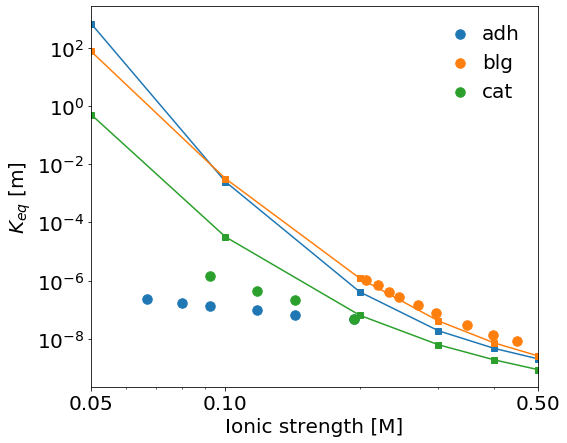

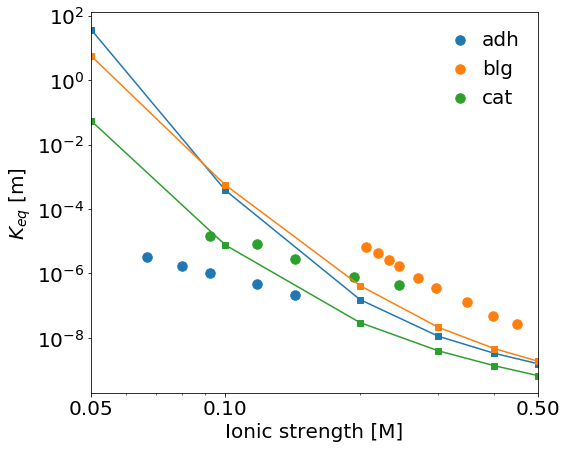

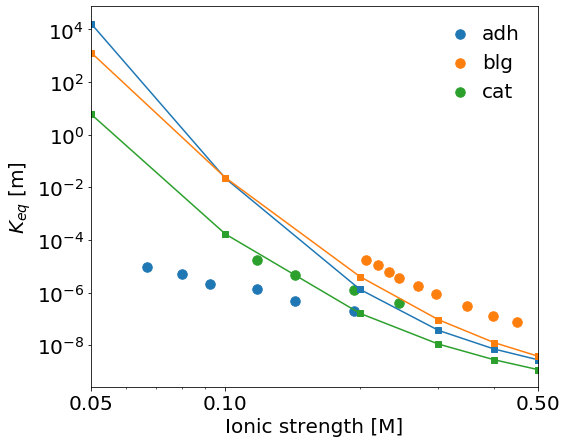

In [20]:
integrand_dir  = 'ns_bim_monomer_spheres/results_potential_lin_to_non_map/integrand_results/'
resin_list     = ['caq', 'phq', 'pxq']
z0 = 3.0e-10 

nsbim_data_dir = 'ns_bim_monomer_spheres/results/ns_bim_data/'
protein_folders = os.listdir(nsbim_data_dir)
protein_folders.sort()

new_list = []
for ind, protein in enumerate(protein_folders):
    if protein.find('ref') == -1:
        new_list.append(protein)

protein_folders = new_list
protein_folders


res = {}
species_pH = {}
for protein in protein_folders:
    species_pH[protein[:protein.rfind('_')]] = 1

for resin in resin_list:
    fig, ax = plt.subplots()
    fig.set_size_inches(8, 7, forward=True)
    font = {'weight' : 'normal',
            'size'   : 20}
    plt.rc('font', **font)
    ax.set_xlabel('Ionic strength [M]')
    ax.set_ylabel(r'$K_{eq}$ [m]')
    ax.set_yscale('log')
    ax.set_xscale('log')
    # # axs.set_ylim(7e-9, 1e-5)
    # ax.set_ylim(7e-9, 1e-4)
    ax.set_xlim(0.05, 0.5)
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.xaxis.set_minor_formatter(NullFormatter())
    ax.set_xticks([0.05, 0.1, 0.5])
    ax.get_xaxis().set_major_formatter(ticker.ScalarFormatter())
    
    for protein in protein_folders:
        if protein[:3] == 'lys':
            pass
        else:
            integrand_df_file = resin + '_' + protein + '.csv'
            Keq = get_model_Keq_v2([ion_str], integrand_df_file, z0, integrand_dir)[0]
            res[protein] = Keq

    for key in species_pH:
        if key[:3] == 'lys':
            pass
        else:
            
            ion_str = []
            Keq = []
            for rkey in res:
                if rkey[:rkey.rfind('_')] == key:
                    ion_str.append(get_ion_str_from_protein_name(rkey))
                    Keq.append(res[rkey])
            order = np.argsort(ion_str)
            xs = np.array(ion_str)[order]
            ys = np.array(Keq)[order]
            ax.plot(xs, ys, 's-')

            df_exp = get_exp_data(key, resin)
            label = key[:3]
            plot_exp_data_v2(ax, df_exp, label)

    fig.savefig('ns_bim_monomer_spheres/results_potential_lin_to_non_map/images/' +\
                resin + '_' + str(int(round(z0*1.0e12))) + '_pm_z0.png', 
                bbox_inches='tight', dpi = 300)

## Calculations with constant potential boundary condition, mapping linear to nonlinear surface potentials, having set histidine charges to +1 

In [13]:
surf_dens_seph = 3.413e-6 # [mol m-2]
surf_dens_caq  = 3.016e-6
surf_dens_phq  = 2.55e-6
surf_dens_pxq  = 3.72e-6

sigma_seph = -1.0 * surf_dens_seph * constants().F # [C m-2]
sigma_caq  = surf_dens_caq * constants().F
sigma_phq  = surf_dens_phq * constants().F
sigma_pxq  = surf_dens_pxq * constants().F

print(sigma_seph, sigma_caq, sigma_phq, sigma_pxq)

-0.329303305 0.29099876 0.24603675000000003 0.35892419999999997


In [14]:
ns_bim_dir      = 'ns_bim_programs_his_pos_charge/'
protein_folders = ['adh_pH_7', 'blg_pH_7', 'cat_pH_7']
ion_str_list    = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5]

In [15]:
for ion_str in ion_str_list:
    for ind, protein in enumerate(protein_folders): 
        prot_dir     = 'ns_bim_monomer_spheres/ns_bim_programs_his_pos_charge/' + protein + '/'
        new_folder   = 'ns_bim_monomer_spheres/results_potential_map_and_his_pos_charge/ns_bim_data/' + protein + '_' +\
                       str(int(ion_str*1.0e3)) + '/'
        meta_run_ns_bim_v2(prot_dir, ion_str, new_folder)

Successfully created the directory ns_bim_monomer_spheres/results_potential_map_and_his_pos_charge/ns_bim_data/adh_pH_7_50/
Successfully created the directory ns_bim_monomer_spheres/results_potential_map_and_his_pos_charge/ns_bim_data/blg_pH_7_50/
Successfully created the directory ns_bim_monomer_spheres/results_potential_map_and_his_pos_charge/ns_bim_data/cat_pH_7_50/
Successfully created the directory ns_bim_monomer_spheres/results_potential_map_and_his_pos_charge/ns_bim_data/adh_pH_7_100/
Successfully created the directory ns_bim_monomer_spheres/results_potential_map_and_his_pos_charge/ns_bim_data/blg_pH_7_100/
Successfully created the directory ns_bim_monomer_spheres/results_potential_map_and_his_pos_charge/ns_bim_data/cat_pH_7_100/
Successfully created the directory ns_bim_monomer_spheres/results_potential_map_and_his_pos_charge/ns_bim_data/adh_pH_7_200/
Successfully created the directory ns_bim_monomer_spheres/results_potential_map_and_his_pos_charge/ns_bim_data/blg_pH_7_200/
Suc

In [28]:
nsbim_data_dir = 'ns_bim_monomer_spheres/results_potential_map_and_his_pos_charge/ns_bim_data/'

protein_folders = os.listdir(nsbim_data_dir)
protein_folders.sort()
protein_folders

['adh_pH_7_100',
 'adh_pH_7_200',
 'adh_pH_7_300',
 'adh_pH_7_400',
 'adh_pH_7_50',
 'adh_pH_7_500',
 'blg_pH_7_100',
 'blg_pH_7_200',
 'blg_pH_7_300',
 'blg_pH_7_400',
 'blg_pH_7_50',
 'blg_pH_7_500',
 'cat_pH_7_100',
 'cat_pH_7_200',
 'cat_pH_7_300',
 'cat_pH_7_400',
 'cat_pH_7_50',
 'cat_pH_7_500']

In [17]:
integrand_dir  = 'ns_bim_monomer_spheres/results_potential_map_and_his_pos_charge/integrand_results/'
energy_dir     = 'ns_bim_monomer_spheres/results_potential_map_and_his_pos_charge/energy_results/'

resin_list = ['caq', 'phq', 'pxq']

for resin in resin_list:
    for name in protein_folders:
        
        ion_str = get_ion_str_from_protein_name(name)
        radius  = get_monomer_radius(name)

        prot_dir   = nsbim_data_dir + name
        start_time = time.time()
        sol        = bulk_solution(ion_str)
        protein    = mono_s.protein_class(name)
        protein.df = mono_s.get_df_elem(prot_dir)
        protein.df['phi_V'] =\
        map_pot_lin_to_nonlin(protein.df['phi_V'], sol)

        kap_h_min   = 0.1
        kap_h_mid   = 1.2
        kap_h_max   = 9.0
        z_min       = kap_h_min/sol.kappa # [m]
        z_mid       = kap_h_mid/sol.kappa
        z_max       = kap_h_max/sol.kappa
        zs = np.concatenate((np.linspace(z_min, z_mid, 30)[:-1], 
                             np.linspace(z_mid, z_max, 21)))

        energy_map_file = 'oc_energy_maps/' + resin + '_' +\
                          str(int(sol.ion_str*1.0e3)) + '_expanded_1.csv'
        energy_fun      = get_interp_fun(energy_map_file)

        args_list = [(protein, i, theta[i], phi[i], zs, energy_fun, sol, radius) for i in range(n)]
        pool      = mp.Pool(processes = mp.cpu_count())
        results   = pool.map(mono_s.get_integrand_list, args_list)
        pool.close()
        pool.join()

        indeces       = [res[0] for res in results]
        integrand_res = [res[1] for res in results]
        energy_res    = [res[2] for res in results]

        new_integrand_df = pd.DataFrame(integrand_res, index=indeces, 
                                        columns=zs)
        new_energy_df    = pd.DataFrame(energy_res, index=indeces, 
                                        columns=zs)

        file = resin + '_' + protein.name + '.csv'
        new_integrand_df.to_csv(integrand_dir + file)
        new_energy_df.to_csv(energy_dir + file)

        print_time((time.time() - start_time)/60.0)
        print('Completed ' + file + ' \n')

0.68
Completed caq_adh_pH_7_100.csv 

0.68
Completed caq_adh_pH_7_200.csv 

0.67
Completed caq_adh_pH_7_300.csv 

0.68
Completed caq_adh_pH_7_400.csv 

0.67
Completed caq_adh_pH_7_50.csv 

0.67
Completed caq_adh_pH_7_500.csv 

0.48
Completed caq_blg_pH_7_100.csv 

0.48
Completed caq_blg_pH_7_200.csv 

0.47
Completed caq_blg_pH_7_300.csv 

0.47
Completed caq_blg_pH_7_400.csv 

0.47
Completed caq_blg_pH_7_50.csv 

0.48
Completed caq_blg_pH_7_500.csv 

0.68
Completed caq_cat_pH_7_100.csv 

0.67
Completed caq_cat_pH_7_200.csv 

0.68
Completed caq_cat_pH_7_300.csv 

0.68
Completed caq_cat_pH_7_400.csv 

0.67
Completed caq_cat_pH_7_50.csv 

0.68
Completed caq_cat_pH_7_500.csv 

0.67
Completed phq_adh_pH_7_100.csv 

0.68
Completed phq_adh_pH_7_200.csv 

0.68
Completed phq_adh_pH_7_300.csv 

0.68
Completed phq_adh_pH_7_400.csv 

0.67
Completed phq_adh_pH_7_50.csv 

0.67
Completed phq_adh_pH_7_500.csv 

0.47
Completed phq_blg_pH_7_100.csv 

0.47
Completed phq_blg_pH_7_200.csv 

0.47
Completed p

[0.05 0.1  0.2  0.3  0.4  0.5 ] 
 [-2.92468596e-09 -1.97571171e-09 -1.21609840e-09 -8.78531958e-10
 -6.82959036e-10 -5.54293627e-10] 


[0.05 0.1  0.2  0.3  0.4  0.5 ] 
 [-2.95351274e-09 -1.94849840e-09 -1.18686808e-09 -8.52403101e-10
 -6.59515772e-10 -5.33016395e-10] 


[0.05 0.1  0.2  0.3  0.4  0.5 ] 
 [-2.77900246e-09 -2.00326276e-09 -1.25579989e-09 -9.13734317e-10
 -7.14159065e-10 -5.82324709e-10] 




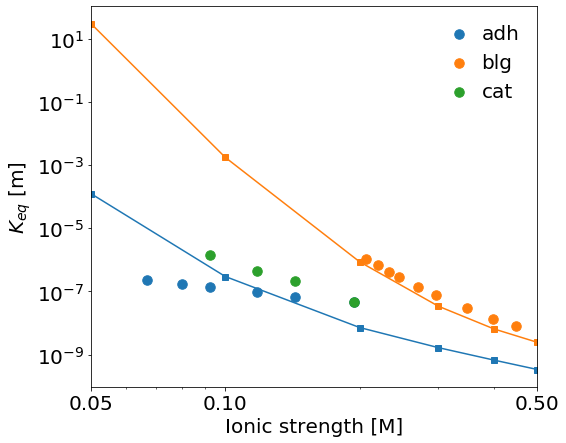

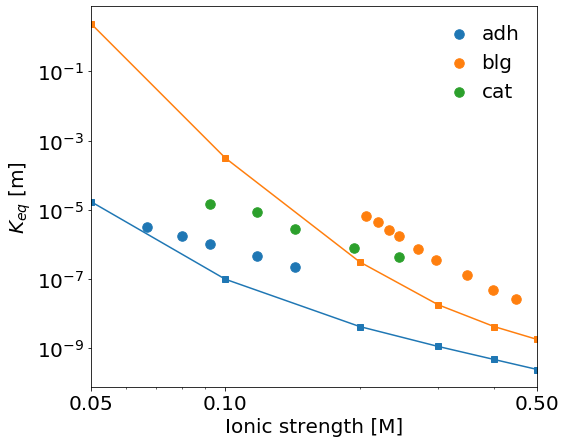

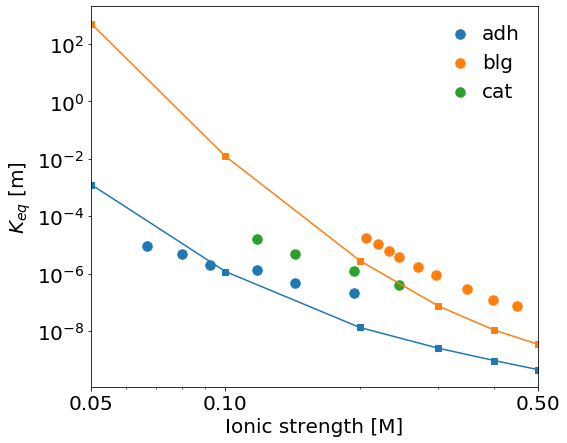

In [27]:
integrand_dir  = 'ns_bim_monomer_spheres/results_potential_map_and_his_pos_charge/integrand_results/'
resin_list     = ['caq', 'phq', 'pxq']
z0 = 3.0e-10 

res = {}
species_pH = {}
for protein in protein_folders:
    species_pH[protein[:protein.rfind('_')]] = 1

for resin in resin_list:
    fig, ax = plt.subplots()
    fig.set_size_inches(8, 7, forward=True)
    font = {'weight' : 'normal',
            'size'   : 20}
    plt.rc('font', **font)
    ax.set_xlabel('Ionic strength [M]')
    ax.set_ylabel(r'$K_{eq}$ [m]')
    ax.set_yscale('log')
    ax.set_xscale('log')
    # # axs.set_ylim(7e-9, 1e-5)
    # ax.set_ylim(7e-9, 1e-4)
    ax.set_xlim(0.05, 0.5)
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.xaxis.set_minor_formatter(NullFormatter())
    ax.set_xticks([0.05, 0.1, 0.5])
    ax.get_xaxis().set_major_formatter(ticker.ScalarFormatter())
    
    for protein in protein_folders:
        if protein[:3] == 'lys':
            pass
        else:
            integrand_df_file = resin + '_' + protein + '.csv'
            Keq = get_model_Keq_v2([ion_str], integrand_df_file, z0, integrand_dir)[0]
            res[protein] = Keq

    for key in species_pH:
        if key[:3] == 'lys':
            pass
        else:
            
            ion_str = []
            Keq = []
            for rkey in res:
                if rkey[:rkey.rfind('_')] == key:
                    ion_str.append(get_ion_str_from_protein_name(rkey))
                    Keq.append(res[rkey])
            order = np.argsort(ion_str)
            xs = np.array(ion_str)[order]
            ys = np.array(Keq)[order]
            
            if key[:3] == 'cat':
                print(xs, '\n', ys, 2*'\n')
            
            ax.plot(xs, ys, 's-')

            df_exp = get_exp_data(key, resin)
            label = key[:3]
            plot_exp_data_v2(ax, df_exp, label)

    fig.savefig('ns_bim_monomer_spheres/results_potential_map_and_his_pos_charge/images/' +\
                resin + '_' + str(int(round(z0*1.0e12))) + '_pm_z0.png', 
                bbox_inches='tight', dpi = 300)

### q_HIS = +1, constant potential BC, but no potential mapping (i.e. directly using the surface potentials from NS-BIM)

In [30]:
integrand_dir  = 'ns_bim_monomer_spheres/results_his_pos_charge/integrand_results/'
energy_dir     = 'ns_bim_monomer_spheres/results_his_pos_charge/energy_results/'

resin_list = ['caq', 'phq', 'pxq']

for resin in resin_list:
    for name in protein_folders:
        
        ion_str = get_ion_str_from_protein_name(name)
        radius  = get_monomer_radius(name)

        prot_dir   = nsbim_data_dir + name
        start_time = time.time()
        sol        = bulk_solution(ion_str)
        protein    = mono_s.protein_class(name)
        protein.df = mono_s.get_df_elem(prot_dir)

        kap_h_min   = 0.1
        kap_h_mid   = 1.2
        kap_h_max   = 9.0
        z_min       = kap_h_min/sol.kappa # [m]
        z_mid       = kap_h_mid/sol.kappa
        z_max       = kap_h_max/sol.kappa
        zs = np.concatenate((np.linspace(z_min, z_mid, 30)[:-1], 
                             np.linspace(z_mid, z_max, 21)))

        energy_map_file = 'oc_energy_maps/' + resin + '_' +\
                          str(int(sol.ion_str*1.0e3)) + '_expanded_1.csv'
        energy_fun      = get_interp_fun(energy_map_file)

        args_list = [(protein, i, theta[i], phi[i], zs, energy_fun, sol, radius) for i in range(n)]
        pool      = mp.Pool(processes = mp.cpu_count())
        results   = pool.map(mono_s.get_integrand_list, args_list)
        pool.close()
        pool.join()

        indeces       = [res[0] for res in results]
        integrand_res = [res[1] for res in results]
        energy_res    = [res[2] for res in results]

        new_integrand_df = pd.DataFrame(integrand_res, index=indeces, 
                                        columns=zs)
        new_energy_df    = pd.DataFrame(energy_res, index=indeces, 
                                        columns=zs)

        file = resin + '_' + protein.name + '.csv'
        new_integrand_df.to_csv(integrand_dir + file)
        new_energy_df.to_csv(energy_dir + file)

        print_time((time.time() - start_time)/60.0)
        print('Completed ' + file + ' \n')

0.64
Completed caq_adh_pH_7_100.csv 

0.66
Completed caq_adh_pH_7_200.csv 

0.65
Completed caq_adh_pH_7_300.csv 

0.65
Completed caq_adh_pH_7_400.csv 

0.66
Completed caq_adh_pH_7_50.csv 

0.66
Completed caq_adh_pH_7_500.csv 

0.47
Completed caq_blg_pH_7_100.csv 

0.47
Completed caq_blg_pH_7_200.csv 

0.47
Completed caq_blg_pH_7_300.csv 

0.47
Completed caq_blg_pH_7_400.csv 

0.47
Completed caq_blg_pH_7_50.csv 

0.47
Completed caq_blg_pH_7_500.csv 

0.67
Completed caq_cat_pH_7_100.csv 

0.68
Completed caq_cat_pH_7_200.csv 

0.68
Completed caq_cat_pH_7_300.csv 

0.71
Completed caq_cat_pH_7_400.csv 

0.70
Completed caq_cat_pH_7_50.csv 

0.70
Completed caq_cat_pH_7_500.csv 

0.69
Completed phq_adh_pH_7_100.csv 

0.68
Completed phq_adh_pH_7_200.csv 

0.70
Completed phq_adh_pH_7_300.csv 

0.71
Completed phq_adh_pH_7_400.csv 

0.69
Completed phq_adh_pH_7_50.csv 

0.69
Completed phq_adh_pH_7_500.csv 

0.48
Completed phq_blg_pH_7_100.csv 

0.48
Completed phq_blg_pH_7_200.csv 

0.48
Completed p

[] 
 [] 


[] 
 [] 


[] 
 [] 




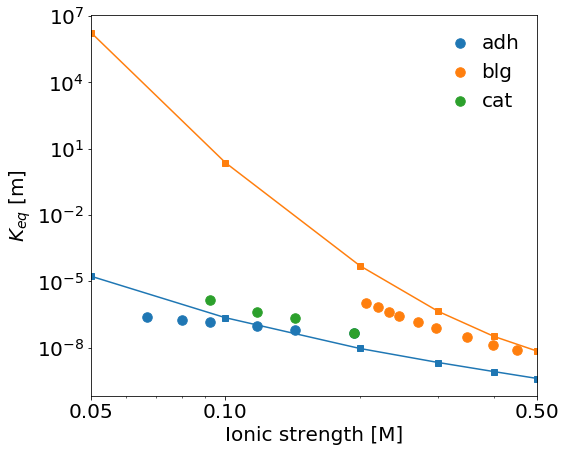

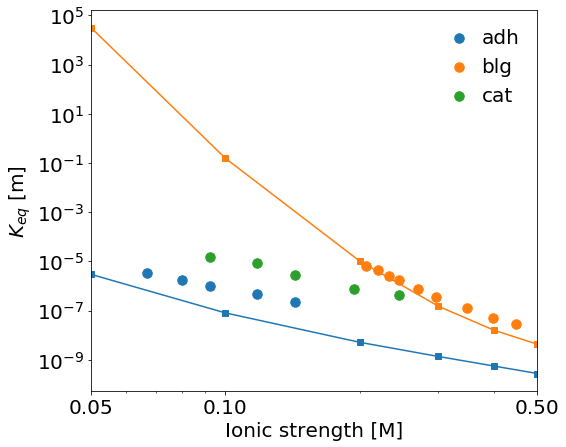

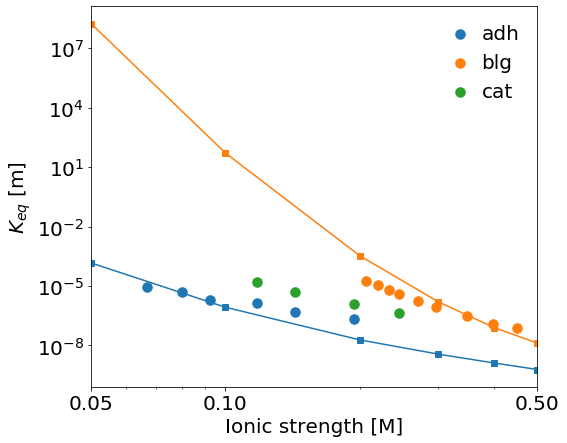

In [33]:
integrand_dir  = 'ns_bim_monomer_spheres/results_his_pos_charge/integrand_results/'
resin_list     = ['caq', 'phq', 'pxq']
z0 = 3.0e-10 

res = {}
species_pH = {}
for protein in protein_folders:
    species_pH[protein[:protein.rfind('_')]] = 1

for resin in resin_list:
    fig, ax = plt.subplots()
    fig.set_size_inches(8, 7, forward=True)
    font = {'weight' : 'normal',
            'size'   : 20}
    plt.rc('font', **font)
    ax.set_xlabel('Ionic strength [M]')
    ax.set_ylabel(r'$K_{eq}$ [m]')
    ax.set_yscale('log')
    ax.set_xscale('log')
    # # axs.set_ylim(7e-9, 1e-5)
    # ax.set_ylim(7e-9, 1e-4)
    ax.set_xlim(0.05, 0.5)
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.xaxis.set_minor_formatter(NullFormatter())
    ax.set_xticks([0.05, 0.1, 0.5])
    ax.get_xaxis().set_major_formatter(ticker.ScalarFormatter())
    
    for protein in protein_folders:
        if protein[:3] == 'lys' or protein[:3] == 'cat':
            pass
        else:
            integrand_df_file = resin + '_' + protein + '.csv'
            Keq = get_model_Keq_v2([ion_str], integrand_df_file, z0, integrand_dir)[0]
            res[protein] = Keq

    for key in species_pH:
        if key[:3] == 'lys':
            pass
        else:
            
            ion_str = []
            Keq = []
            for rkey in res:
                if rkey[:rkey.rfind('_')] == key:
                    ion_str.append(get_ion_str_from_protein_name(rkey))
                    Keq.append(res[rkey])
            order = np.argsort(ion_str)
            xs = np.array(ion_str)[order]
            ys = np.array(Keq)[order]
            
            ax.plot(xs, ys, 's-')

            df_exp = get_exp_data(key, resin)
            label = key[:3]
            plot_exp_data_v2(ax, df_exp, label)

    fig.savefig('ns_bim_monomer_spheres/results_his_pos_charge/images/' +\
                resin + '_' + str(int(round(z0*1.0e12))) + '_pm_z0.png', 
                bbox_inches='tight', dpi = 300)

### q_HIS = +0.5, constant potential BC, but potential mapping (i.e. directly using the surface potentials from NS-BIM)

In [7]:
surf_dens_seph = 3.413e-6 # [mol m-2]
surf_dens_caq  = 3.016e-6
surf_dens_phq  = 2.55e-6
surf_dens_pxq  = 3.72e-6

sigma_seph = -1.0 * surf_dens_seph * constants().F # [C m-2]
sigma_caq  = surf_dens_caq * constants().F
sigma_phq  = surf_dens_phq * constants().F
sigma_pxq  = surf_dens_pxq * constants().F

print(sigma_seph, sigma_caq, sigma_phq, sigma_pxq)

-0.329303305 0.29099876 0.24603675000000003 0.35892419999999997


In [8]:
ns_bim_dir      = 'ns_bim_programs_his_0pt5/'
protein_folders = ['adh_pH_7', 'blg_pH_7', 'cat_pH_7']
ion_str_list    = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5]

In [9]:
for ion_str in ion_str_list:
    for ind, protein in enumerate(protein_folders): 
        prot_dir     = 'ns_bim_monomer_spheres/ns_bim_programs_his_0pt5/' + protein + '/'
        new_folder   = 'ns_bim_monomer_spheres/results_his_0pt5/ns_bim_data/' + protein + '_' +\
                       str(int(ion_str*1.0e3)) + '/'
        meta_run_ns_bim_v2(prot_dir, ion_str, new_folder)

Successfully created the directory ns_bim_monomer_spheres/results_his_0pt5/ns_bim_data/adh_pH_7_50/
Successfully created the directory ns_bim_monomer_spheres/results_his_0pt5/ns_bim_data/blg_pH_7_50/
Successfully created the directory ns_bim_monomer_spheres/results_his_0pt5/ns_bim_data/cat_pH_7_50/
Successfully created the directory ns_bim_monomer_spheres/results_his_0pt5/ns_bim_data/adh_pH_7_100/
Successfully created the directory ns_bim_monomer_spheres/results_his_0pt5/ns_bim_data/blg_pH_7_100/
Successfully created the directory ns_bim_monomer_spheres/results_his_0pt5/ns_bim_data/cat_pH_7_100/
Successfully created the directory ns_bim_monomer_spheres/results_his_0pt5/ns_bim_data/adh_pH_7_200/
Successfully created the directory ns_bim_monomer_spheres/results_his_0pt5/ns_bim_data/blg_pH_7_200/
Successfully created the directory ns_bim_monomer_spheres/results_his_0pt5/ns_bim_data/cat_pH_7_200/
Successfully created the directory ns_bim_monomer_spheres/results_his_0pt5/ns_bim_data/adh_pH_

In [10]:
nsbim_data_dir = 'ns_bim_monomer_spheres/results_his_0pt5/ns_bim_data/'

protein_folders = os.listdir(nsbim_data_dir)
protein_folders.sort()
protein_folders

['adh_pH_7_100',
 'adh_pH_7_200',
 'adh_pH_7_300',
 'adh_pH_7_400',
 'adh_pH_7_50',
 'adh_pH_7_500',
 'blg_pH_7_100',
 'blg_pH_7_200',
 'blg_pH_7_300',
 'blg_pH_7_400',
 'blg_pH_7_50',
 'blg_pH_7_500',
 'cat_pH_7_100',
 'cat_pH_7_200',
 'cat_pH_7_300',
 'cat_pH_7_400',
 'cat_pH_7_50',
 'cat_pH_7_500']

In [11]:
integrand_dir  = 'ns_bim_monomer_spheres/results_his_0pt5/integrand_results/'
resin_list = ['caq', 'phq', 'pxq']

for resin in resin_list:
    for name in protein_folders:
        
        ion_str = get_ion_str_from_protein_name(name)
        radius  = get_monomer_radius(name)

        prot_dir   = nsbim_data_dir + name
        start_time = time.time()
        sol        = bulk_solution(ion_str)
        protein    = mono_s.protein_class(name)
        protein.df = mono_s.get_df_elem(prot_dir)

        kap_h_min   = 0.1
        kap_h_mid   = 1.2
        kap_h_max   = 9.0
        z_min       = kap_h_min/sol.kappa # [m]
        z_mid       = kap_h_mid/sol.kappa
        z_max       = kap_h_max/sol.kappa
        zs = np.concatenate((np.linspace(z_min, z_mid, 30)[:-1], 
                             np.linspace(z_mid, z_max, 21)))

        energy_map_file = 'oc_energy_maps/' + resin + '_' +\
                          str(int(sol.ion_str*1.0e3)) + '_expanded_1.csv'
        energy_fun      = get_interp_fun(energy_map_file)

        args_list = [(protein, i, theta[i], phi[i], zs, energy_fun, sol, radius) for i in range(n)]
        pool      = mp.Pool(processes = mp.cpu_count())
        results   = pool.map(mono_s.get_integrand_list, args_list)
        pool.close()
        pool.join()

        indeces       = [res[0] for res in results]
        integrand_res = [res[1] for res in results]
        energy_res    = [res[2] for res in results]

        new_integrand_df = pd.DataFrame(integrand_res, index=indeces, 
                                        columns=zs)
        new_energy_df    = pd.DataFrame(energy_res, index=indeces, 
                                        columns=zs)

        file = resin + '_' + protein.name + '.csv'
        new_integrand_df.to_csv(integrand_dir + file)
#         new_energy_df.to_csv(energy_dir + file)

        print_time((time.time() - start_time)/60.0)
        print('Completed ' + file + ' \n')

0.66
Completed caq_adh_pH_7_100.csv 

0.66
Completed caq_adh_pH_7_200.csv 

0.66
Completed caq_adh_pH_7_300.csv 

0.66
Completed caq_adh_pH_7_400.csv 

0.66
Completed caq_adh_pH_7_50.csv 

0.66
Completed caq_adh_pH_7_500.csv 

0.46
Completed caq_blg_pH_7_100.csv 

0.45
Completed caq_blg_pH_7_200.csv 

0.45
Completed caq_blg_pH_7_300.csv 

0.46
Completed caq_blg_pH_7_400.csv 

0.46
Completed caq_blg_pH_7_50.csv 

0.45
Completed caq_blg_pH_7_500.csv 

0.65
Completed caq_cat_pH_7_100.csv 

0.66
Completed caq_cat_pH_7_200.csv 

0.66
Completed caq_cat_pH_7_300.csv 

0.66
Completed caq_cat_pH_7_400.csv 

0.65
Completed caq_cat_pH_7_50.csv 

0.66
Completed caq_cat_pH_7_500.csv 

0.66
Completed phq_adh_pH_7_100.csv 

0.66
Completed phq_adh_pH_7_200.csv 

0.66
Completed phq_adh_pH_7_300.csv 

0.67
Completed phq_adh_pH_7_400.csv 

0.66
Completed phq_adh_pH_7_50.csv 

0.66
Completed phq_adh_pH_7_500.csv 

0.46
Completed phq_blg_pH_7_100.csv 

0.46
Completed phq_blg_pH_7_200.csv 

0.46
Completed p

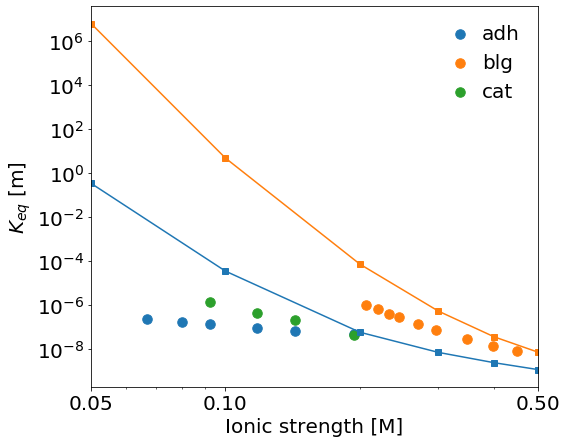

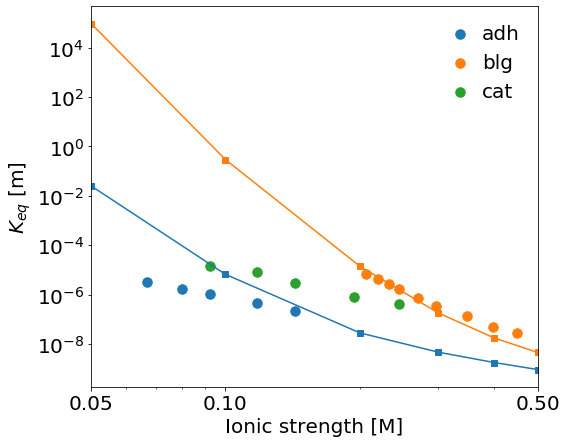

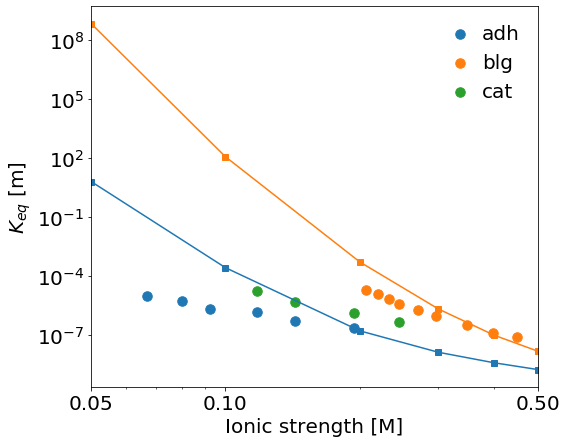

In [13]:
integrand_dir  = 'ns_bim_monomer_spheres/results_his_0pt5/integrand_results/'
resin_list     = ['caq', 'phq', 'pxq']
z0 = 3.0e-10 

res = {}
species_pH = {}
for protein in protein_folders:
    species_pH[protein[:protein.rfind('_')]] = 1

for resin in resin_list:
    fig, ax = plt.subplots()
    fig.set_size_inches(8, 7, forward=True)
    font = {'weight' : 'normal',
            'size'   : 20}
    plt.rc('font', **font)
    ax.set_xlabel('Ionic strength [M]')
    ax.set_ylabel(r'$K_{eq}$ [m]')
    ax.set_yscale('log')
    ax.set_xscale('log')
    # # axs.set_ylim(7e-9, 1e-5)
    # ax.set_ylim(7e-9, 1e-4)
    ax.set_xlim(0.05, 0.5)
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.xaxis.set_minor_formatter(NullFormatter())
    ax.set_xticks([0.05, 0.1, 0.5])
    ax.get_xaxis().set_major_formatter(ticker.ScalarFormatter())
    
    for protein in protein_folders:
        if protein[:3] == 'lys' or protein[:3] == 'cat':
            pass
        else:
            integrand_df_file = resin + '_' + protein + '.csv'
            Keq = get_model_Keq_v2([ion_str], integrand_df_file, z0, integrand_dir)[0]
            res[protein] = Keq

    for key in species_pH:
        if key[:3] == 'lys':
            pass
        else:
            
            ion_str = []
            Keq = []
            for rkey in res:
                if rkey[:rkey.rfind('_')] == key:
                    ion_str.append(get_ion_str_from_protein_name(rkey))
                    Keq.append(res[rkey])
            order = np.argsort(ion_str)
            xs = np.array(ion_str)[order]
            ys = np.array(Keq)[order]
            
            ax.plot(xs, ys, 's-')

            df_exp = get_exp_data(key, resin)
            label = key[:3]
            plot_exp_data_v2(ax, df_exp, label)

    fig.savefig('ns_bim_monomer_spheres/results_his_0pt5/images/' +\
                resin + '_' + str(int(round(z0*1.0e12))) + '_pm_z0.png', 
                bbox_inches='tight', dpi = 300)

# PQR partial charges

In [5]:
ns_bim_dir      = 'ns_bim_programs_pqr_partial_charges/'
protein_folders = ['adh_pH_7', 'blg_pH_7', 'cat_pH_7']
ion_str_list    = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5]

In [6]:
for ion_str in ion_str_list:
    for ind, protein in enumerate(protein_folders): 
        prot_dir     = 'ns_bim_monomer_spheres/ns_bim_programs_pqr_partial_charges/' + protein + '/'
        new_folder   = 'ns_bim_monomer_spheres/results_pqr_partial_charges/ns_bim_data/' + protein + '_' +\
                       str(int(ion_str*1.0e3)) + '/'
        meta_run_ns_bim_v2(prot_dir, ion_str, new_folder)

Successfully created the directory ns_bim_monomer_spheres/results_pqr_partial_charges/ns_bim_data/adh_pH_7_50/
Successfully created the directory ns_bim_monomer_spheres/results_pqr_partial_charges/ns_bim_data/blg_pH_7_50/
Successfully created the directory ns_bim_monomer_spheres/results_pqr_partial_charges/ns_bim_data/cat_pH_7_50/
Successfully created the directory ns_bim_monomer_spheres/results_pqr_partial_charges/ns_bim_data/adh_pH_7_100/
Successfully created the directory ns_bim_monomer_spheres/results_pqr_partial_charges/ns_bim_data/blg_pH_7_100/
Successfully created the directory ns_bim_monomer_spheres/results_pqr_partial_charges/ns_bim_data/cat_pH_7_100/
Successfully created the directory ns_bim_monomer_spheres/results_pqr_partial_charges/ns_bim_data/adh_pH_7_200/
Successfully created the directory ns_bim_monomer_spheres/results_pqr_partial_charges/ns_bim_data/blg_pH_7_200/
Successfully created the directory ns_bim_monomer_spheres/results_pqr_partial_charges/ns_bim_data/cat_pH_7_

In [7]:
nsbim_data_dir = 'ns_bim_monomer_spheres/results_pqr_partial_charges/ns_bim_data/'

protein_folders = os.listdir(nsbim_data_dir)
protein_folders.sort()
protein_folders

['adh_pH_7_100',
 'adh_pH_7_200',
 'adh_pH_7_300',
 'adh_pH_7_400',
 'adh_pH_7_50',
 'adh_pH_7_500',
 'blg_pH_7_100',
 'blg_pH_7_200',
 'blg_pH_7_300',
 'blg_pH_7_400',
 'blg_pH_7_50',
 'blg_pH_7_500',
 'cat_pH_7_100',
 'cat_pH_7_200',
 'cat_pH_7_300',
 'cat_pH_7_400',
 'cat_pH_7_50',
 'cat_pH_7_500']

In [8]:
integrand_dir = 'ns_bim_monomer_spheres/results_pqr_partial_charges/integrand_results/'
images_dir    = 'ns_bim_monomer_spheres/results_pqr_partial_charges/images/'

my_mk_dir(integrand_dir)
my_mk_dir(images_dir)

Successfully created the directory ns_bim_monomer_spheres/results_pqr_partial_charges/integrand_results/
Successfully created the directory ns_bim_monomer_spheres/results_pqr_partial_charges/images/


In [9]:
n = 5000

if n >= 600000:
    epsilon = 214
elif n>= 400000:
    epsilon = 75
elif n>= 11000:
    epsilon = 27
elif n>= 890:
    epsilon = 10
elif n>= 177:
    epsilon = 3.33
elif n>= 24:
    epsilon = 1.33
else:
    epsilon = 0.33

goldenRatio = (1 + 5**0.5)/2
i = np.arange(0, n) 
phi = 2 * np.pi * i / goldenRatio
theta = np.arccos(1 - 2*(i+epsilon)/(n-1+2*epsilon))

In [12]:
resin_list = ['caq', 'phq', 'pxq']

for resin in resin_list:
    for name in protein_folders:
        
        ion_str = get_ion_str_from_protein_name(name)
        radius  = get_monomer_radius(name)

        prot_dir   = nsbim_data_dir + name
        start_time = time.time()
        sol        = bulk_solution(ion_str)
        protein    = mono_s.protein_class(name)
        protein.df = mono_s.get_df_elem(prot_dir)

        kap_h_min   = 0.1
        kap_h_mid   = 1.2
        kap_h_max   = 9.0
        z_min       = kap_h_min/sol.kappa # [m]
        z_mid       = kap_h_mid/sol.kappa
        z_max       = kap_h_max/sol.kappa
        zs = np.concatenate((np.linspace(z_min, z_mid, 30)[:-1], 
                             np.linspace(z_mid, z_max, 21)))

        energy_map_file = 'oc_energy_maps/' + resin + '_' +\
                          str(int(sol.ion_str*1.0e3)) + '_expanded_1.csv'
        energy_fun      = get_interp_fun(energy_map_file)

        args_list = [(protein, i, theta[i], phi[i], zs, energy_fun, sol, radius) for i in range(n)]
        pool      = mp.Pool(processes = mp.cpu_count())
        results   = pool.map(mono_s.get_integrand_list, args_list)
        pool.close()
        pool.join()

        indeces       = [res[0] for res in results]
        integrand_res = [res[1] for res in results]
        energy_res    = [res[2] for res in results]

        new_integrand_df = pd.DataFrame(integrand_res, index=indeces, 
                                        columns=zs)
        new_energy_df    = pd.DataFrame(energy_res, index=indeces, 
                                        columns=zs)

        file = resin + '_' + protein.name + '.csv'
        new_integrand_df.to_csv(integrand_dir + file)

        print_time((time.time() - start_time)/60.0)
        print('Completed ' + file + ' \n')

0.63
Completed caq_adh_pH_7_100.csv 

0.62
Completed caq_adh_pH_7_200.csv 

0.63
Completed caq_adh_pH_7_300.csv 

0.62
Completed caq_adh_pH_7_400.csv 

0.62
Completed caq_adh_pH_7_50.csv 

0.63
Completed caq_adh_pH_7_500.csv 

0.44
Completed caq_blg_pH_7_100.csv 

0.43
Completed caq_blg_pH_7_200.csv 

0.44
Completed caq_blg_pH_7_300.csv 

0.44
Completed caq_blg_pH_7_400.csv 

0.44
Completed caq_blg_pH_7_50.csv 

0.44
Completed caq_blg_pH_7_500.csv 

0.63
Completed caq_cat_pH_7_100.csv 

0.64
Completed caq_cat_pH_7_200.csv 

0.64
Completed caq_cat_pH_7_300.csv 

0.63
Completed caq_cat_pH_7_400.csv 

0.64
Completed caq_cat_pH_7_50.csv 

0.63
Completed caq_cat_pH_7_500.csv 

0.64
Completed phq_adh_pH_7_100.csv 

0.63
Completed phq_adh_pH_7_200.csv 

0.64
Completed phq_adh_pH_7_300.csv 

0.64
Completed phq_adh_pH_7_400.csv 

0.63
Completed phq_adh_pH_7_50.csv 

0.64
Completed phq_adh_pH_7_500.csv 

0.44
Completed phq_blg_pH_7_100.csv 

0.44
Completed phq_blg_pH_7_200.csv 

0.44
Completed p

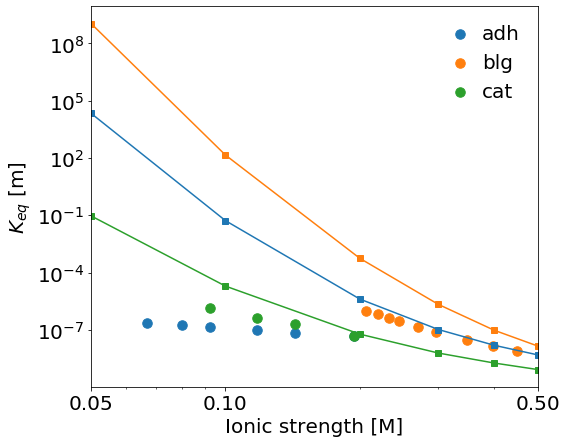

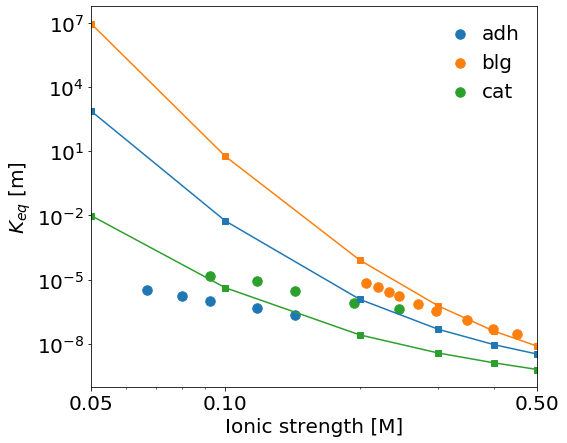

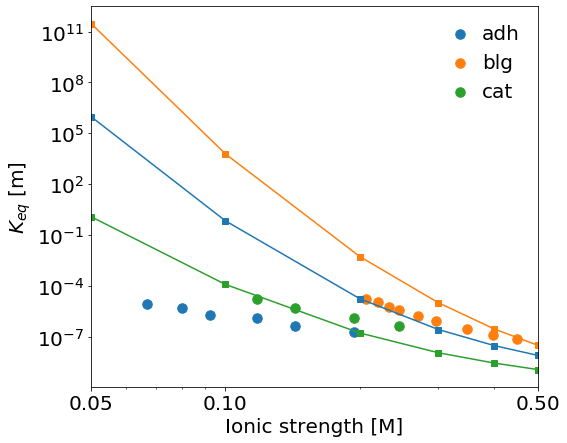

In [14]:
z0 = 3.0e-10 

res = {}
species_pH = {}
for protein in protein_folders:
    species_pH[protein[:protein.rfind('_')]] = 1

for resin in resin_list:
    fig, ax = plt.subplots()
    fig.set_size_inches(8, 7, forward=True)
    font = {'weight' : 'normal',
            'size'   : 20}
    plt.rc('font', **font)
    ax.set_xlabel('Ionic strength [M]')
    ax.set_ylabel(r'$K_{eq}$ [m]')
    ax.set_yscale('log')
    ax.set_xscale('log')
    # # axs.set_ylim(7e-9, 1e-5)
    # ax.set_ylim(7e-9, 1e-4)
    ax.set_xlim(0.05, 0.5)
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.xaxis.set_minor_formatter(NullFormatter())
    ax.set_xticks([0.05, 0.1, 0.5])
    ax.get_xaxis().set_major_formatter(ticker.ScalarFormatter())
    
    for protein in protein_folders:
        integrand_df_file = resin + '_' + protein + '.csv'
        Keq = get_model_Keq_v2([ion_str], integrand_df_file, z0, integrand_dir)[0]
        res[protein] = Keq

    for key in species_pH:
        ion_str = []
        Keq = []
        for rkey in res:
            if rkey[:rkey.rfind('_')] == key:
                ion_str.append(get_ion_str_from_protein_name(rkey))
                Keq.append(res[rkey])
        order = np.argsort(ion_str)
        xs = np.array(ion_str)[order]
        ys = np.array(Keq)[order]
        ax.plot(xs, ys, 's-')

        df_exp = get_exp_data(key, resin)
        label = key[:3]
        plot_exp_data_v2(ax, df_exp, label)

    fig.savefig(images_dir + resin + '_' + str(int(round(z0*1.0e12))) + '_pm_z0.png', 
                bbox_inches='tight', dpi = 300)

# PQR partial charges, modified ADH coordination (coord) groups

In [6]:
ns_bim_dir      = 'ns_bim_programs_pqr_partial_charges_mod_adh/'
protein_folders = ['adh_pH_7']
ion_str_list    = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5]

In [7]:
for ion_str in ion_str_list:
    for ind, protein in enumerate(protein_folders): 
        prot_dir     = 'ns_bim_monomer_spheres/ns_bim_programs_pqr_partial_charges_mod_adh/' + protein + '/'
        new_folder   = 'ns_bim_monomer_spheres/results_pqr_partial_charges_mod_adh/ns_bim_data/' + protein + '_' +\
                       str(int(ion_str*1.0e3)) + '/'
        meta_run_ns_bim_v2(prot_dir, ion_str, new_folder)

Successfully created the directory ns_bim_monomer_spheres/results_pqr_partial_charges_mod_adh/ns_bim_data/adh_pH_7_50/
Successfully created the directory ns_bim_monomer_spheres/results_pqr_partial_charges_mod_adh/ns_bim_data/adh_pH_7_100/
Successfully created the directory ns_bim_monomer_spheres/results_pqr_partial_charges_mod_adh/ns_bim_data/adh_pH_7_200/
Successfully created the directory ns_bim_monomer_spheres/results_pqr_partial_charges_mod_adh/ns_bim_data/adh_pH_7_300/
Successfully created the directory ns_bim_monomer_spheres/results_pqr_partial_charges_mod_adh/ns_bim_data/adh_pH_7_400/
Successfully created the directory ns_bim_monomer_spheres/results_pqr_partial_charges_mod_adh/ns_bim_data/adh_pH_7_500/


In [8]:
nsbim_data_dir = 'ns_bim_monomer_spheres/results_pqr_partial_charges_mod_adh/ns_bim_data/'

protein_folders = os.listdir(nsbim_data_dir)
protein_folders.sort()
protein_folders

['adh_pH_7_100',
 'adh_pH_7_200',
 'adh_pH_7_300',
 'adh_pH_7_400',
 'adh_pH_7_50',
 'adh_pH_7_500']

In [9]:
integrand_dir = 'ns_bim_monomer_spheres/results_pqr_partial_charges_mod_adh/integrand_results/'
images_dir    = 'ns_bim_monomer_spheres/results_pqr_partial_charges_mod_adh/images/'

my_mk_dir(integrand_dir)
my_mk_dir(images_dir)

Successfully created the directory ns_bim_monomer_spheres/results_pqr_partial_charges_mod_adh/integrand_results/
Successfully created the directory ns_bim_monomer_spheres/results_pqr_partial_charges_mod_adh/images/


In [11]:
n = 5000

if n >= 600000:
    epsilon = 214
elif n>= 400000:
    epsilon = 75
elif n>= 11000:
    epsilon = 27
elif n>= 890:
    epsilon = 10
elif n>= 177:
    epsilon = 3.33
elif n>= 24:
    epsilon = 1.33
else:
    epsilon = 0.33

goldenRatio = (1 + 5**0.5)/2
i = np.arange(0, n) 
phi = 2 * np.pi * i / goldenRatio
theta = np.arccos(1 - 2*(i+epsilon)/(n-1+2*epsilon))

In [15]:
resin_list = ['caq', 'phq', 'pxq']

for resin in resin_list:
    for name in protein_folders:
        
        ion_str = get_ion_str_from_protein_name(name)
        radius  = get_monomer_radius(name)

        prot_dir   = nsbim_data_dir + name
        start_time = time.time()
        sol        = bulk_solution(ion_str)
        protein    = mono_s.protein_class(name)
        protein.df = mono_s.get_df_elem(prot_dir)

        kap_h_min   = 0.1
        kap_h_mid   = 1.2
        kap_h_max   = 9.0
        z_min       = kap_h_min/sol.kappa # [m]
        z_mid       = kap_h_mid/sol.kappa
        z_max       = kap_h_max/sol.kappa
        zs = np.concatenate((np.linspace(z_min, z_mid, 30)[:-1], 
                             np.linspace(z_mid, z_max, 21)))

        energy_map_file = 'oc_energy_maps/' + resin + '_' +\
                          str(int(sol.ion_str*1.0e3)) + '_expanded_1.csv'
        energy_fun      = get_interp_fun(energy_map_file)

        args_list = [(protein, i, theta[i], phi[i], zs, energy_fun, sol, radius) for i in range(n)]
        pool      = mp.Pool(processes = mp.cpu_count())
        results   = pool.map(mono_s.get_integrand_list, args_list)
        pool.close()
        pool.join()

        indeces       = [res[0] for res in results]
        integrand_res = [res[1] for res in results]
        energy_res    = [res[2] for res in results]

        new_integrand_df = pd.DataFrame(integrand_res, index=indeces, 
                                        columns=zs)
        new_energy_df    = pd.DataFrame(energy_res, index=indeces, 
                                        columns=zs)

        file = resin + '_' + protein.name + '.csv'
        new_integrand_df.to_csv(integrand_dir + file)

        print_time((time.time() - start_time)/60.0)
        print('Completed ' + file + ' \n')

0.64
Completed caq_adh_pH_7_100.csv 

0.64
Completed caq_adh_pH_7_200.csv 

0.65
Completed caq_adh_pH_7_300.csv 

0.66
Completed caq_adh_pH_7_400.csv 

0.66
Completed caq_adh_pH_7_50.csv 

0.66
Completed caq_adh_pH_7_500.csv 

0.66
Completed phq_adh_pH_7_100.csv 

0.67
Completed phq_adh_pH_7_200.csv 

0.66
Completed phq_adh_pH_7_300.csv 

0.67
Completed phq_adh_pH_7_400.csv 

0.67
Completed phq_adh_pH_7_50.csv 

0.67
Completed phq_adh_pH_7_500.csv 

0.67
Completed pxq_adh_pH_7_100.csv 

0.66
Completed pxq_adh_pH_7_200.csv 

0.67
Completed pxq_adh_pH_7_300.csv 

0.66
Completed pxq_adh_pH_7_400.csv 

0.66
Completed pxq_adh_pH_7_50.csv 

0.67
Completed pxq_adh_pH_7_500.csv 



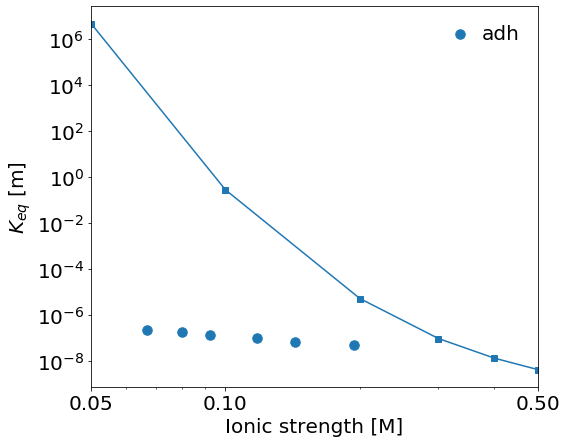

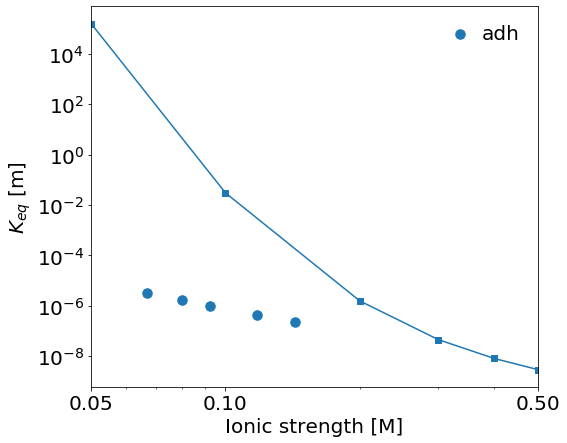

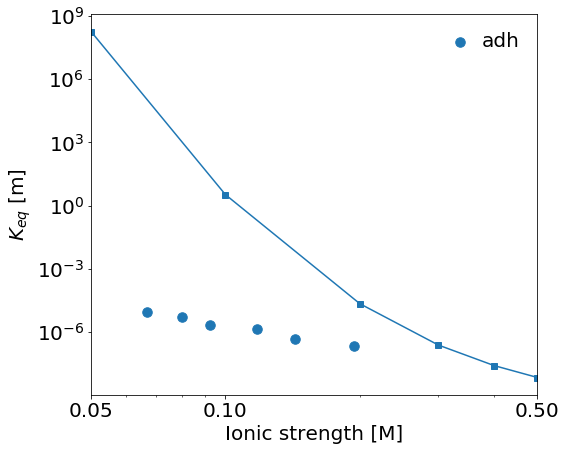

In [16]:
z0 = 3.0e-10 

res = {}
species_pH = {}
for protein in protein_folders:
    species_pH[protein[:protein.rfind('_')]] = 1

for resin in resin_list:
    fig, ax = plt.subplots()
    fig.set_size_inches(8, 7, forward=True)
    font = {'weight' : 'normal',
            'size'   : 20}
    plt.rc('font', **font)
    ax.set_xlabel('Ionic strength [M]')
    ax.set_ylabel(r'$K_{eq}$ [m]')
    ax.set_yscale('log')
    ax.set_xscale('log')
    # # axs.set_ylim(7e-9, 1e-5)
    # ax.set_ylim(7e-9, 1e-4)
    ax.set_xlim(0.05, 0.5)
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.xaxis.set_minor_formatter(NullFormatter())
    ax.set_xticks([0.05, 0.1, 0.5])
    ax.get_xaxis().set_major_formatter(ticker.ScalarFormatter())
    
    for protein in protein_folders:
        integrand_df_file = resin + '_' + protein + '.csv'
        Keq = get_model_Keq_v2([ion_str], integrand_df_file, z0, integrand_dir)[0]
        res[protein] = Keq

    for key in species_pH:
        ion_str = []
        Keq = []
        for rkey in res:
            if rkey[:rkey.rfind('_')] == key:
                ion_str.append(get_ion_str_from_protein_name(rkey))
                Keq.append(res[rkey])
        order = np.argsort(ion_str)
        xs = np.array(ion_str)[order]
        ys = np.array(Keq)[order]
        ax.plot(xs, ys, 's-')

        df_exp = get_exp_data(key, resin)
        label = key[:3]
        plot_exp_data_v2(ax, df_exp, label)

    fig.savefig(images_dir + resin + '_' + str(int(round(z0*1.0e12))) + '_pm_z0.png', 
                bbox_inches='tight', dpi = 300)

# Monte Carlo assignment of charge locations

## Set-up - always run

In [63]:
parent_dir       = 'ns_bim_monomer_spheres/ns_bim_programs_pqr_mc/'
q_dir_name       = 'pqr_discrete_charges/'
ns_bim_dir_name  = 'charge_and_potential_base/'
src_fil_name     = 'Input_Source.dat'

protein_folders = os.listdir(parent_dir)
protein_folders.sort()

depth = 0.15 # [nm]

## Place charges and run NS-BIM

In [69]:
n_iterations = 30
ion_str_list = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5]


In [70]:
protein = 'cat_pH_7'    

protein_dir = parent_dir + protein + '/'
src_fil     = protein_dir + ns_bim_dir_name + src_fil_name

mc_q_dir   = protein_dir + 'mc_charge_locations/'
mc_res_dir = protein_dir + 'mc_results/'
my_mk_dir(mc_q_dir)
my_mk_dir(mc_res_dir)

q_dir       = protein_dir + q_dir_name
q_files     = os.listdir(q_dir)
q_files.sort()

for i in range(n_iterations):
    iter_q_dir = mc_q_dir + 'iteration_' + str(i) + '/'
    my_mk_dir(iter_q_dir)
    q_dict = {}

    for q_fil in q_files:
        mono_num                = int(q_fil[q_fil.rfind('.') - 1])
        q_dict[mono_num]        = mono_s.monomer()
        q_dict[mono_num].q_df   = pd.read_csv(q_dir + q_fil)
        q_dict[mono_num].center = mono_s.get_mono_center(protein, mono_num)
        radius                  = mono_s.get_mono_radius(protein)
        radius_q                = radius - depth
        q_dict[mono_num].q_df   = mc.place_charges(q_dict[mono_num].q_df, radius_q, 
                                                     q_dict[mono_num].center)
        q_dict[mono_num].q_df.to_csv(iter_q_dir + 'monomer_' + str(mono_num)  + '.csv')

    mono_s.mono_update_input_source(q_dict, src_fil)

    for ion_str in ion_str_list:
        curr_res_dir = mc_res_dir + str(int(ion_str*1000)) + '_iteration_' + str(i) + '/'
        meta_run_ns_bim_v2(protein_dir, ion_str, curr_res_dir)
        print('\n')

Successfully created the directory ns_bim_monomer_spheres/ns_bim_programs_pqr_mc/cat_pH_7/mc_charge_locations/
Successfully created the directory ns_bim_monomer_spheres/ns_bim_programs_pqr_mc/cat_pH_7/mc_results/
Successfully created the directory ns_bim_monomer_spheres/ns_bim_programs_pqr_mc/cat_pH_7/mc_charge_locations/iteration_0/
Successfully created the directory ns_bim_monomer_spheres/ns_bim_programs_pqr_mc/cat_pH_7/mc_results/50_iteration_0/


Successfully created the directory ns_bim_monomer_spheres/ns_bim_programs_pqr_mc/cat_pH_7/mc_results/100_iteration_0/


Successfully created the directory ns_bim_monomer_spheres/ns_bim_programs_pqr_mc/cat_pH_7/mc_results/200_iteration_0/


Successfully created the directory ns_bim_monomer_spheres/ns_bim_programs_pqr_mc/cat_pH_7/mc_results/300_iteration_0/


Successfully created the directory ns_bim_monomer_spheres/ns_bim_programs_pqr_mc/cat_pH_7/mc_results/400_iteration_0/


Successfully created the directory ns_bim_monomer_spheres/ns_bim_



Successfully created the directory ns_bim_monomer_spheres/ns_bim_programs_pqr_mc/cat_pH_7/mc_results/300_iteration_9/


Successfully created the directory ns_bim_monomer_spheres/ns_bim_programs_pqr_mc/cat_pH_7/mc_results/400_iteration_9/


Successfully created the directory ns_bim_monomer_spheres/ns_bim_programs_pqr_mc/cat_pH_7/mc_results/500_iteration_9/


Successfully created the directory ns_bim_monomer_spheres/ns_bim_programs_pqr_mc/cat_pH_7/mc_charge_locations/iteration_10/
Successfully created the directory ns_bim_monomer_spheres/ns_bim_programs_pqr_mc/cat_pH_7/mc_results/50_iteration_10/


Successfully created the directory ns_bim_monomer_spheres/ns_bim_programs_pqr_mc/cat_pH_7/mc_results/100_iteration_10/


Successfully created the directory ns_bim_monomer_spheres/ns_bim_programs_pqr_mc/cat_pH_7/mc_results/200_iteration_10/


Successfully created the directory ns_bim_monomer_spheres/ns_bim_programs_pqr_mc/cat_pH_7/mc_results/300_iteration_10/


Successfully created the direct



Successfully created the directory ns_bim_monomer_spheres/ns_bim_programs_pqr_mc/cat_pH_7/mc_results/100_iteration_19/


Successfully created the directory ns_bim_monomer_spheres/ns_bim_programs_pqr_mc/cat_pH_7/mc_results/200_iteration_19/


Successfully created the directory ns_bim_monomer_spheres/ns_bim_programs_pqr_mc/cat_pH_7/mc_results/300_iteration_19/


Successfully created the directory ns_bim_monomer_spheres/ns_bim_programs_pqr_mc/cat_pH_7/mc_results/400_iteration_19/


Successfully created the directory ns_bim_monomer_spheres/ns_bim_programs_pqr_mc/cat_pH_7/mc_results/500_iteration_19/


Successfully created the directory ns_bim_monomer_spheres/ns_bim_programs_pqr_mc/cat_pH_7/mc_charge_locations/iteration_20/
Successfully created the directory ns_bim_monomer_spheres/ns_bim_programs_pqr_mc/cat_pH_7/mc_results/50_iteration_20/


Successfully created the directory ns_bim_monomer_spheres/ns_bim_programs_pqr_mc/cat_pH_7/mc_results/100_iteration_20/


Successfully created the dir



Successfully created the directory ns_bim_monomer_spheres/ns_bim_programs_pqr_mc/cat_pH_7/mc_charge_locations/iteration_29/
Successfully created the directory ns_bim_monomer_spheres/ns_bim_programs_pqr_mc/cat_pH_7/mc_results/50_iteration_29/


Successfully created the directory ns_bim_monomer_spheres/ns_bim_programs_pqr_mc/cat_pH_7/mc_results/100_iteration_29/


Successfully created the directory ns_bim_monomer_spheres/ns_bim_programs_pqr_mc/cat_pH_7/mc_results/200_iteration_29/


Successfully created the directory ns_bim_monomer_spheres/ns_bim_programs_pqr_mc/cat_pH_7/mc_results/300_iteration_29/


Successfully created the directory ns_bim_monomer_spheres/ns_bim_programs_pqr_mc/cat_pH_7/mc_results/400_iteration_29/


Successfully created the directory ns_bim_monomer_spheres/ns_bim_programs_pqr_mc/cat_pH_7/mc_results/500_iteration_29/




## Run ND model

In [71]:
z0 = 3.0e-10 
n = 5000

if n >= 600000:
    epsilon = 214
elif n>= 400000:
    epsilon = 75
elif n>= 11000:
    epsilon = 27
elif n>= 890:
    epsilon = 10
elif n>= 177:
    epsilon = 3.33
elif n>= 24:
    epsilon = 1.33
else:
    epsilon = 0.33

goldenRatio = (1 + 5**0.5)/2
i = np.arange(0, n) 
phi = 2 * np.pi * i / goldenRatio
theta = np.arccos(1 - 2*(i+epsilon)/(n-1+2*epsilon))

In [72]:
name   = 'cat_pH_7'
resin  = 'phq'
radius = get_monomer_radius(name)

mc_keq_dir = protein_dir + 'mc_keq_results/'
my_mk_dir(mc_keq_dir)

for ion_str in ion_str_list:
    sol = bulk_solution(ion_str)
    ion_str_string = str(int(ion_str*1000))

    for i in range(n_iterations): 
        data_dir = mc_res_dir + ion_str_string + '_iteration_' + str(i) + '/'

        start_time = time.time()
        protein    = mono_s.protein_class(name)
        protein.df = mono_s.get_df_elem(data_dir)

        kap_h_min   = 0.1
        kap_h_mid   = 1.2
        kap_h_max   = 9.0
        z_min       = kap_h_min/sol.kappa # [m]
        z_mid       = kap_h_mid/sol.kappa
        z_max       = kap_h_max/sol.kappa
        zs = np.concatenate((np.linspace(z_min, z_mid, 30)[:-1], 
                             np.linspace(z_mid, z_max, 21)))

        energy_map_file = 'oc_energy_maps/' + resin + '_' +\
                          str(int(sol.ion_str*1.0e3)) + '_expanded_1.csv'
        energy_fun      = get_interp_fun(energy_map_file)

        args_list = [(protein, j, theta[j], phi[j], zs, energy_fun, sol, radius) for j in range(n)]
        pool      = mp.Pool(processes = mp.cpu_count())
        results   = pool.map(mono_s.get_integrand_list, args_list)
        pool.close()
        pool.join()

        indeces       = [res[0] for res in results]
        integrand_res = [res[1] for res in results]
        df_integrand  = pd.DataFrame(integrand_res, index=indeces, columns=zs)

        try:
            df_keq = pd.read_csv(mc_keq_dir + ion_str_string + '.csv', index_col=0)
        except FileNotFoundError:
            df_keq = pd.DataFrame()

        keq = get_model_Keq_v2([ion_str], 'ignore', z0, 'ignore', df_integrand)[0]
        df_keq.at[i, 'keq_m'] = keq
        df_keq.to_csv(mc_keq_dir + ion_str_string + '.csv')

        print_time((time.time() - start_time)/60.0)
        print('Completed ' + ion_str_string + '_iteration_' + str(i) + ' \n')

Successfully created the directory ns_bim_monomer_spheres/ns_bim_programs_pqr_mc/cat_pH_7/mc_keq_results/
0.64
Completed 50_iteration_0 

0.64
Completed 50_iteration_1 

0.65
Completed 50_iteration_2 

0.66
Completed 50_iteration_3 

0.67
Completed 50_iteration_4 

0.68
Completed 50_iteration_5 

0.68
Completed 50_iteration_6 

0.68
Completed 50_iteration_7 

0.70
Completed 50_iteration_8 

0.69
Completed 50_iteration_9 

0.69
Completed 50_iteration_10 

0.68
Completed 50_iteration_11 

0.67
Completed 50_iteration_12 

0.68
Completed 50_iteration_13 

0.70
Completed 50_iteration_14 

0.69
Completed 50_iteration_15 

0.70
Completed 50_iteration_16 

0.68
Completed 50_iteration_17 

0.71
Completed 50_iteration_18 

0.67
Completed 50_iteration_19 

0.71
Completed 50_iteration_20 

0.69
Completed 50_iteration_21 

0.72
Completed 50_iteration_22 

0.69
Completed 50_iteration_23 

0.67
Completed 50_iteration_24 

0.69
Completed 50_iteration_25 

0.68
Completed 50_iteration_26 

0.69
Complete

## Plot results

Creation of the directory ns_bim_monomer_spheres/ns_bim_programs_pqr_mc/adh_pH_7/mc_keq_results/images/ failed


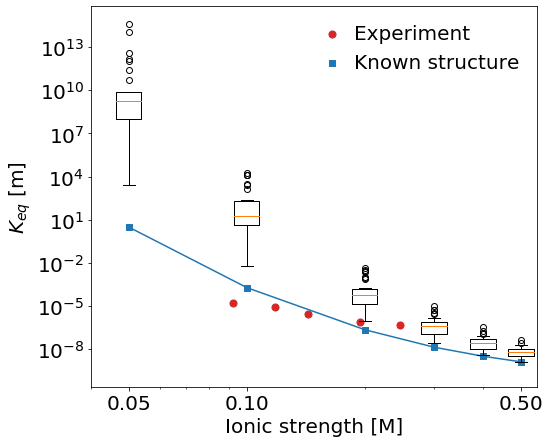

In [90]:
protein = 'cat_pH_7'
dir_destin = mc_keq_dir + 'images/'
my_mk_dir(dir_destin)

fig, ax = plt.subplots()
fig.set_size_inches(8, 7, forward=True)
font = {'weight': 'normal', 'size': 20}
plt.rc('font', **font)
ax.set_xlabel('Ionic strength [M]')
ax.set_ylabel(r'$K_{eq}$ [m]')
ax.set_yscale('log')
ax.set_xscale('log')


# Plot experimental data
df_exp = get_exp_data(protein, resin)
ax.scatter(df_exp['IS(M)'], df_exp['Keq'], marker='o', s=50, label='Experiment',
           color='#d62728')  


# Plot prediction from known structure
integrand_dir = 'ns_bim_monomer_spheres/results/integrand_results/'
Keq_list = []
for ion_str in ion_str_list:
    ion_str_string = str(int(ion_str*1000)) 
    integrand_df_file = resin + '_' + protein + '_' + ion_str_string + '.csv'
    Keq = get_model_Keq_v2([ion_str], integrand_df_file, z0, integrand_dir)[0]
    Keq_list.append(Keq)
    
ax.scatter(ion_str_list, Keq_list, marker='s', label='Known structure')
ax.plot(ion_str_list, Keq_list)


# Plot box and whisker plots
data = []
for ion_str in ion_str_list:
    ion_str_string = str(int(ion_str*1.0e3))
    df_keq = pd.read_csv(mc_keq_dir + ion_str_string + '.csv', index_col=0)
    data.append(list(df_keq['keq_m']))

widths = []
factor = 0.15
for ion_str in ion_str_list:
    widths.append(factor*ion_str)
    
plt.boxplot(data, positions=ion_str_list, widths=widths)



ax.set_xlim(0.04, 0.55)
ax.xaxis.set_major_formatter(NullFormatter())
ax.xaxis.set_minor_formatter(NullFormatter())
ax.set_xticks([0.05, 0.1, 0.5])
ax.get_xaxis().set_major_formatter(ticker.ScalarFormatter())

handles, labels = ax.get_legend_handles_labels()
new_handles = []
for h in handles:
    #only need to edit the errorbar legend entries
    if isinstance(h, container.ErrorbarContainer):
        new_handles.append(h[0])
    else:
        new_handles.append(h)
ax.legend(new_handles, labels, loc='best', frameon=False, handletextpad=0.1)

fig.savefig(dir_destin + 'mc_' + protein + '.png', bbox_inches='tight', dpi = 300)

In [77]:
protein = 'blg_pH_7'    

protein_dir = parent_dir + protein + '/'
src_fil     = protein_dir + ns_bim_dir_name + src_fil_name

mc_q_dir   = protein_dir + 'mc_charge_locations/'
mc_res_dir = protein_dir + 'mc_results/'
my_mk_dir(mc_q_dir)
my_mk_dir(mc_res_dir)

q_dir       = protein_dir + q_dir_name
q_files     = os.listdir(q_dir)
q_files.sort()

for i in range(n_iterations):
    iter_q_dir = mc_q_dir + 'iteration_' + str(i) + '/'
    my_mk_dir(iter_q_dir)
    q_dict = {}

    for q_fil in q_files:
        mono_num                = int(q_fil[q_fil.rfind('.') - 1])
        q_dict[mono_num]        = mono_s.monomer()
        q_dict[mono_num].q_df   = pd.read_csv(q_dir + q_fil)
        q_dict[mono_num].center = mono_s.get_mono_center(protein, mono_num)
        radius                  = mono_s.get_mono_radius(protein)
        radius_q                = radius - depth
        q_dict[mono_num].q_df   = mc.place_charges(q_dict[mono_num].q_df, radius_q, 
                                                     q_dict[mono_num].center)
        q_dict[mono_num].q_df.to_csv(iter_q_dir + 'monomer_' + str(mono_num)  + '.csv')

    mono_s.mono_update_input_source(q_dict, src_fil)

    for ion_str in ion_str_list:
        curr_res_dir = mc_res_dir + str(int(ion_str*1000)) + '_iteration_' + str(i) + '/'
        meta_run_ns_bim_v2(protein_dir, ion_str, curr_res_dir)
        print('\n')

Creation of the directory ns_bim_monomer_spheres/ns_bim_programs_pqr_mc/blg_pH_7/mc_charge_locations/ failed
Creation of the directory ns_bim_monomer_spheres/ns_bim_programs_pqr_mc/blg_pH_7/mc_results/ failed
Creation of the directory ns_bim_monomer_spheres/ns_bim_programs_pqr_mc/blg_pH_7/mc_charge_locations/iteration_0/ failed
Successfully created the directory ns_bim_monomer_spheres/ns_bim_programs_pqr_mc/blg_pH_7/mc_results/50_iteration_0/


Successfully created the directory ns_bim_monomer_spheres/ns_bim_programs_pqr_mc/blg_pH_7/mc_results/100_iteration_0/


Successfully created the directory ns_bim_monomer_spheres/ns_bim_programs_pqr_mc/blg_pH_7/mc_results/200_iteration_0/


Successfully created the directory ns_bim_monomer_spheres/ns_bim_programs_pqr_mc/blg_pH_7/mc_results/300_iteration_0/


Successfully created the directory ns_bim_monomer_spheres/ns_bim_programs_pqr_mc/blg_pH_7/mc_results/400_iteration_0/


Successfully created the directory ns_bim_monomer_spheres/ns_bim_progra



Successfully created the directory ns_bim_monomer_spheres/ns_bim_programs_pqr_mc/blg_pH_7/mc_results/300_iteration_9/


Successfully created the directory ns_bim_monomer_spheres/ns_bim_programs_pqr_mc/blg_pH_7/mc_results/400_iteration_9/


Successfully created the directory ns_bim_monomer_spheres/ns_bim_programs_pqr_mc/blg_pH_7/mc_results/500_iteration_9/


Successfully created the directory ns_bim_monomer_spheres/ns_bim_programs_pqr_mc/blg_pH_7/mc_charge_locations/iteration_10/
Successfully created the directory ns_bim_monomer_spheres/ns_bim_programs_pqr_mc/blg_pH_7/mc_results/50_iteration_10/


Successfully created the directory ns_bim_monomer_spheres/ns_bim_programs_pqr_mc/blg_pH_7/mc_results/100_iteration_10/


Successfully created the directory ns_bim_monomer_spheres/ns_bim_programs_pqr_mc/blg_pH_7/mc_results/200_iteration_10/


Successfully created the directory ns_bim_monomer_spheres/ns_bim_programs_pqr_mc/blg_pH_7/mc_results/300_iteration_10/


Successfully created the direct



Successfully created the directory ns_bim_monomer_spheres/ns_bim_programs_pqr_mc/blg_pH_7/mc_results/100_iteration_19/


Successfully created the directory ns_bim_monomer_spheres/ns_bim_programs_pqr_mc/blg_pH_7/mc_results/200_iteration_19/


Successfully created the directory ns_bim_monomer_spheres/ns_bim_programs_pqr_mc/blg_pH_7/mc_results/300_iteration_19/


Successfully created the directory ns_bim_monomer_spheres/ns_bim_programs_pqr_mc/blg_pH_7/mc_results/400_iteration_19/


Successfully created the directory ns_bim_monomer_spheres/ns_bim_programs_pqr_mc/blg_pH_7/mc_results/500_iteration_19/


Successfully created the directory ns_bim_monomer_spheres/ns_bim_programs_pqr_mc/blg_pH_7/mc_charge_locations/iteration_20/
Successfully created the directory ns_bim_monomer_spheres/ns_bim_programs_pqr_mc/blg_pH_7/mc_results/50_iteration_20/


Successfully created the directory ns_bim_monomer_spheres/ns_bim_programs_pqr_mc/blg_pH_7/mc_results/100_iteration_20/


Successfully created the dir



Successfully created the directory ns_bim_monomer_spheres/ns_bim_programs_pqr_mc/blg_pH_7/mc_charge_locations/iteration_29/
Successfully created the directory ns_bim_monomer_spheres/ns_bim_programs_pqr_mc/blg_pH_7/mc_results/50_iteration_29/


Successfully created the directory ns_bim_monomer_spheres/ns_bim_programs_pqr_mc/blg_pH_7/mc_results/100_iteration_29/


Successfully created the directory ns_bim_monomer_spheres/ns_bim_programs_pqr_mc/blg_pH_7/mc_results/200_iteration_29/


Successfully created the directory ns_bim_monomer_spheres/ns_bim_programs_pqr_mc/blg_pH_7/mc_results/300_iteration_29/


Successfully created the directory ns_bim_monomer_spheres/ns_bim_programs_pqr_mc/blg_pH_7/mc_results/400_iteration_29/


Successfully created the directory ns_bim_monomer_spheres/ns_bim_programs_pqr_mc/blg_pH_7/mc_results/500_iteration_29/




## Run ND model

In [78]:
z0 = 3.0e-10 
n = 5000

if n >= 600000:
    epsilon = 214
elif n>= 400000:
    epsilon = 75
elif n>= 11000:
    epsilon = 27
elif n>= 890:
    epsilon = 10
elif n>= 177:
    epsilon = 3.33
elif n>= 24:
    epsilon = 1.33
else:
    epsilon = 0.33

goldenRatio = (1 + 5**0.5)/2
i = np.arange(0, n) 
phi = 2 * np.pi * i / goldenRatio
theta = np.arccos(1 - 2*(i+epsilon)/(n-1+2*epsilon))

In [79]:
name   = 'blg_pH_7'
resin  = 'phq'
radius = get_monomer_radius(name)

mc_keq_dir = protein_dir + 'mc_keq_results/'
my_mk_dir(mc_keq_dir)

for ion_str in ion_str_list:
    sol = bulk_solution(ion_str)
    ion_str_string = str(int(ion_str*1000))

    for i in range(n_iterations): 
        data_dir = mc_res_dir + ion_str_string + '_iteration_' + str(i) + '/'

        start_time = time.time()
        protein    = mono_s.protein_class(name)
        protein.df = mono_s.get_df_elem(data_dir)

        kap_h_min   = 0.1
        kap_h_mid   = 1.2
        kap_h_max   = 9.0
        z_min       = kap_h_min/sol.kappa # [m]
        z_mid       = kap_h_mid/sol.kappa
        z_max       = kap_h_max/sol.kappa
        zs = np.concatenate((np.linspace(z_min, z_mid, 30)[:-1], 
                             np.linspace(z_mid, z_max, 21)))

        energy_map_file = 'oc_energy_maps/' + resin + '_' +\
                          str(int(sol.ion_str*1.0e3)) + '_expanded_1.csv'
        energy_fun      = get_interp_fun(energy_map_file)

        args_list = [(protein, j, theta[j], phi[j], zs, energy_fun, sol, radius) for j in range(n)]
        pool      = mp.Pool(processes = mp.cpu_count())
        results   = pool.map(mono_s.get_integrand_list, args_list)
        pool.close()
        pool.join()

        indeces       = [res[0] for res in results]
        integrand_res = [res[1] for res in results]
        df_integrand  = pd.DataFrame(integrand_res, index=indeces, columns=zs)

        try:
            df_keq = pd.read_csv(mc_keq_dir + ion_str_string + '.csv', index_col=0)
        except FileNotFoundError:
            df_keq = pd.DataFrame()

        keq = get_model_Keq_v2([ion_str], 'ignore', z0, 'ignore', df_integrand)[0]
        df_keq.at[i, 'keq_m'] = keq
        df_keq.to_csv(mc_keq_dir + ion_str_string + '.csv')

        print_time((time.time() - start_time)/60.0)
        print('Completed ' + ion_str_string + '_iteration_' + str(i) + ' \n')

Successfully created the directory ns_bim_monomer_spheres/ns_bim_programs_pqr_mc/blg_pH_7/mc_keq_results/
0.45
Completed 50_iteration_0 

0.45
Completed 50_iteration_1 

0.44
Completed 50_iteration_2 

0.45
Completed 50_iteration_3 

0.44
Completed 50_iteration_4 

0.44
Completed 50_iteration_5 

0.45
Completed 50_iteration_6 

0.45
Completed 50_iteration_7 

0.45
Completed 50_iteration_8 

0.45
Completed 50_iteration_9 

0.44
Completed 50_iteration_10 

0.45
Completed 50_iteration_11 

0.45
Completed 50_iteration_12 

0.44
Completed 50_iteration_13 

0.45
Completed 50_iteration_14 

0.45
Completed 50_iteration_15 

0.45
Completed 50_iteration_16 

0.45
Completed 50_iteration_17 

0.45
Completed 50_iteration_18 

0.45
Completed 50_iteration_19 

0.45
Completed 50_iteration_20 

0.45
Completed 50_iteration_21 

0.44
Completed 50_iteration_22 

0.44
Completed 50_iteration_23 

0.45
Completed 50_iteration_24 

0.45
Completed 50_iteration_25 

0.45
Completed 50_iteration_26 

0.45
Complete

## Plot results

Creation of the directory ns_bim_monomer_spheres/ns_bim_programs_pqr_mc/adh_pH_7/mc_keq_results/images/ failed


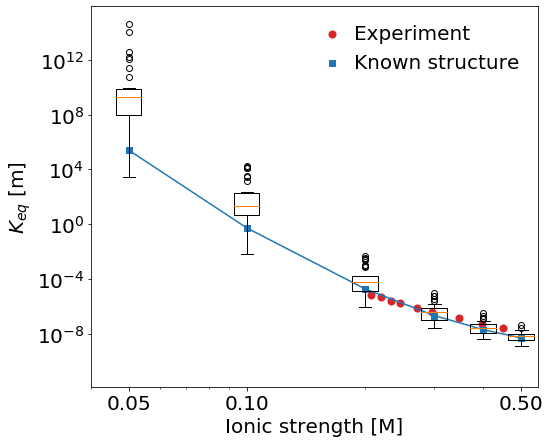

In [88]:
protein = 'blg_pH_7'
dir_destin = mc_keq_dir + 'images/'
my_mk_dir(dir_destin)

fig, ax = plt.subplots()
fig.set_size_inches(8, 7, forward=True)
font = {'weight': 'normal', 'size': 20}
plt.rc('font', **font)
ax.set_xlabel('Ionic strength [M]')
ax.set_ylabel(r'$K_{eq}$ [m]')
ax.set_yscale('log')
ax.set_xscale('log')


# Plot experimental data
df_exp = get_exp_data(protein, resin)
ax.scatter(df_exp['IS(M)'], df_exp['Keq'], marker='o', s=50, label='Experiment',
           color='#d62728')  


# Plot prediction from known structure
integrand_dir = 'ns_bim_monomer_spheres/results/integrand_results/'
Keq_list = []
for ion_str in ion_str_list:
    ion_str_string = str(int(ion_str*1000)) 
    integrand_df_file = resin + '_' + protein + '_' + ion_str_string + '.csv'
    Keq = get_model_Keq_v2([ion_str], integrand_df_file, z0, integrand_dir)[0]
    Keq_list.append(Keq)
    
ax.scatter(ion_str_list, Keq_list, marker='s', label='Known structure')
ax.plot(ion_str_list, Keq_list)


# Plot box and whisker plots
data = []
for ion_str in ion_str_list:
    ion_str_string = str(int(ion_str*1.0e3))
    df_keq = pd.read_csv(mc_keq_dir + ion_str_string + '.csv', index_col=0)
    data.append(list(df_keq['keq_m']))

widths = []
factor = 0.15
for ion_str in ion_str_list:
    widths.append(factor*ion_str)
    
plt.boxplot(data, positions=ion_str_list, widths=widths)



ax.set_xlim(0.04, 0.55)
ax.xaxis.set_major_formatter(NullFormatter())
ax.xaxis.set_minor_formatter(NullFormatter())
ax.set_xticks([0.05, 0.1, 0.5])
ax.get_xaxis().set_major_formatter(ticker.ScalarFormatter())

handles, labels = ax.get_legend_handles_labels()
new_handles = []
for h in handles:
    #only need to edit the errorbar legend entries
    if isinstance(h, container.ErrorbarContainer):
        new_handles.append(h[0])
    else:
        new_handles.append(h)
ax.legend(new_handles, labels, loc='best', frameon=False, handletextpad=0.1)

fig.savefig(dir_destin + 'mc_' + protein + '.png', bbox_inches='tight', dpi = 300)

In [81]:
protein = 'adh_pH_7'    

protein_dir = parent_dir + protein + '/'
src_fil     = protein_dir + ns_bim_dir_name + src_fil_name

mc_q_dir   = protein_dir + 'mc_charge_locations/'
mc_res_dir = protein_dir + 'mc_results/'
my_mk_dir(mc_q_dir)
my_mk_dir(mc_res_dir)

q_dir       = protein_dir + q_dir_name
q_files     = os.listdir(q_dir)
q_files.sort()

for i in range(n_iterations):
    iter_q_dir = mc_q_dir + 'iteration_' + str(i) + '/'
    my_mk_dir(iter_q_dir)
    q_dict = {}

    for q_fil in q_files:
        mono_num                = int(q_fil[q_fil.rfind('.') - 1])
        q_dict[mono_num]        = mono_s.monomer()
        q_dict[mono_num].q_df   = pd.read_csv(q_dir + q_fil)
        q_dict[mono_num].center = mono_s.get_mono_center(protein, mono_num)
        radius                  = mono_s.get_mono_radius(protein)
        radius_q                = radius - depth
        q_dict[mono_num].q_df   = mc.place_charges(q_dict[mono_num].q_df, radius_q, 
                                                     q_dict[mono_num].center)
        q_dict[mono_num].q_df.to_csv(iter_q_dir + 'monomer_' + str(mono_num)  + '.csv')

    mono_s.mono_update_input_source(q_dict, src_fil)

    for ion_str in ion_str_list:
        curr_res_dir = mc_res_dir + str(int(ion_str*1000)) + '_iteration_' + str(i) + '/'
        meta_run_ns_bim_v2(protein_dir, ion_str, curr_res_dir)
        print('\n')

Creation of the directory ns_bim_monomer_spheres/ns_bim_programs_pqr_mc/adh_pH_7/mc_charge_locations/ failed
Creation of the directory ns_bim_monomer_spheres/ns_bim_programs_pqr_mc/adh_pH_7/mc_results/ failed
Creation of the directory ns_bim_monomer_spheres/ns_bim_programs_pqr_mc/adh_pH_7/mc_charge_locations/iteration_0/ failed
Creation of the directory ns_bim_monomer_spheres/ns_bim_programs_pqr_mc/adh_pH_7/mc_results/50_iteration_0/ failed


Creation of the directory ns_bim_monomer_spheres/ns_bim_programs_pqr_mc/adh_pH_7/mc_results/100_iteration_0/ failed


Creation of the directory ns_bim_monomer_spheres/ns_bim_programs_pqr_mc/adh_pH_7/mc_results/200_iteration_0/ failed


Creation of the directory ns_bim_monomer_spheres/ns_bim_programs_pqr_mc/adh_pH_7/mc_results/300_iteration_0/ failed


Creation of the directory ns_bim_monomer_spheres/ns_bim_programs_pqr_mc/adh_pH_7/mc_results/400_iteration_0/ failed


Creation of the directory ns_bim_monomer_spheres/ns_bim_programs_pqr_mc/adh_pH_7/



Successfully created the directory ns_bim_monomer_spheres/ns_bim_programs_pqr_mc/adh_pH_7/mc_results/300_iteration_9/


Successfully created the directory ns_bim_monomer_spheres/ns_bim_programs_pqr_mc/adh_pH_7/mc_results/400_iteration_9/


Successfully created the directory ns_bim_monomer_spheres/ns_bim_programs_pqr_mc/adh_pH_7/mc_results/500_iteration_9/


Successfully created the directory ns_bim_monomer_spheres/ns_bim_programs_pqr_mc/adh_pH_7/mc_charge_locations/iteration_10/
Successfully created the directory ns_bim_monomer_spheres/ns_bim_programs_pqr_mc/adh_pH_7/mc_results/50_iteration_10/


Successfully created the directory ns_bim_monomer_spheres/ns_bim_programs_pqr_mc/adh_pH_7/mc_results/100_iteration_10/


Successfully created the directory ns_bim_monomer_spheres/ns_bim_programs_pqr_mc/adh_pH_7/mc_results/200_iteration_10/


Successfully created the directory ns_bim_monomer_spheres/ns_bim_programs_pqr_mc/adh_pH_7/mc_results/300_iteration_10/


Successfully created the direct



Successfully created the directory ns_bim_monomer_spheres/ns_bim_programs_pqr_mc/adh_pH_7/mc_results/100_iteration_19/


Successfully created the directory ns_bim_monomer_spheres/ns_bim_programs_pqr_mc/adh_pH_7/mc_results/200_iteration_19/


Successfully created the directory ns_bim_monomer_spheres/ns_bim_programs_pqr_mc/adh_pH_7/mc_results/300_iteration_19/


Successfully created the directory ns_bim_monomer_spheres/ns_bim_programs_pqr_mc/adh_pH_7/mc_results/400_iteration_19/


Successfully created the directory ns_bim_monomer_spheres/ns_bim_programs_pqr_mc/adh_pH_7/mc_results/500_iteration_19/


Successfully created the directory ns_bim_monomer_spheres/ns_bim_programs_pqr_mc/adh_pH_7/mc_charge_locations/iteration_20/
Successfully created the directory ns_bim_monomer_spheres/ns_bim_programs_pqr_mc/adh_pH_7/mc_results/50_iteration_20/


Successfully created the directory ns_bim_monomer_spheres/ns_bim_programs_pqr_mc/adh_pH_7/mc_results/100_iteration_20/


Successfully created the dir



Successfully created the directory ns_bim_monomer_spheres/ns_bim_programs_pqr_mc/adh_pH_7/mc_charge_locations/iteration_29/
Successfully created the directory ns_bim_monomer_spheres/ns_bim_programs_pqr_mc/adh_pH_7/mc_results/50_iteration_29/


Successfully created the directory ns_bim_monomer_spheres/ns_bim_programs_pqr_mc/adh_pH_7/mc_results/100_iteration_29/


Successfully created the directory ns_bim_monomer_spheres/ns_bim_programs_pqr_mc/adh_pH_7/mc_results/200_iteration_29/


Successfully created the directory ns_bim_monomer_spheres/ns_bim_programs_pqr_mc/adh_pH_7/mc_results/300_iteration_29/


Successfully created the directory ns_bim_monomer_spheres/ns_bim_programs_pqr_mc/adh_pH_7/mc_results/400_iteration_29/


Successfully created the directory ns_bim_monomer_spheres/ns_bim_programs_pqr_mc/adh_pH_7/mc_results/500_iteration_29/




## Run ND model

In [82]:
z0 = 3.0e-10 
n = 5000

if n >= 600000:
    epsilon = 214
elif n>= 400000:
    epsilon = 75
elif n>= 11000:
    epsilon = 27
elif n>= 890:
    epsilon = 10
elif n>= 177:
    epsilon = 3.33
elif n>= 24:
    epsilon = 1.33
else:
    epsilon = 0.33

goldenRatio = (1 + 5**0.5)/2
i = np.arange(0, n) 
phi = 2 * np.pi * i / goldenRatio
theta = np.arccos(1 - 2*(i+epsilon)/(n-1+2*epsilon))

In [83]:
name   = 'adh_pH_7'
resin  = 'phq'
radius = get_monomer_radius(name)

mc_keq_dir = protein_dir + 'mc_keq_results/'
my_mk_dir(mc_keq_dir)

for ion_str in ion_str_list:
    sol = bulk_solution(ion_str)
    ion_str_string = str(int(ion_str*1000))

    for i in range(n_iterations): 
        data_dir = mc_res_dir + ion_str_string + '_iteration_' + str(i) + '/'

        start_time = time.time()
        protein    = mono_s.protein_class(name)
        protein.df = mono_s.get_df_elem(data_dir)

        kap_h_min   = 0.1
        kap_h_mid   = 1.2
        kap_h_max   = 9.0
        z_min       = kap_h_min/sol.kappa # [m]
        z_mid       = kap_h_mid/sol.kappa
        z_max       = kap_h_max/sol.kappa
        zs = np.concatenate((np.linspace(z_min, z_mid, 30)[:-1], 
                             np.linspace(z_mid, z_max, 21)))

        energy_map_file = 'oc_energy_maps/' + resin + '_' +\
                          str(int(sol.ion_str*1.0e3)) + '_expanded_1.csv'
        energy_fun      = get_interp_fun(energy_map_file)

        args_list = [(protein, j, theta[j], phi[j], zs, energy_fun, sol, radius) for j in range(n)]
        pool      = mp.Pool(processes = mp.cpu_count())
        results   = pool.map(mono_s.get_integrand_list, args_list)
        pool.close()
        pool.join()

        indeces       = [res[0] for res in results]
        integrand_res = [res[1] for res in results]
        df_integrand  = pd.DataFrame(integrand_res, index=indeces, columns=zs)

        try:
            df_keq = pd.read_csv(mc_keq_dir + ion_str_string + '.csv', index_col=0)
        except FileNotFoundError:
            df_keq = pd.DataFrame()

        keq = get_model_Keq_v2([ion_str], 'ignore', z0, 'ignore', df_integrand)[0]
        df_keq.at[i, 'keq_m'] = keq
        df_keq.to_csv(mc_keq_dir + ion_str_string + '.csv')

        print_time((time.time() - start_time)/60.0)
        print('Completed ' + ion_str_string + '_iteration_' + str(i) + ' \n')

Successfully created the directory ns_bim_monomer_spheres/ns_bim_programs_pqr_mc/adh_pH_7/mc_keq_results/
0.65
Completed 50_iteration_0 

0.65
Completed 50_iteration_1 

0.65
Completed 50_iteration_2 

0.65
Completed 50_iteration_3 

0.65
Completed 50_iteration_4 

0.65
Completed 50_iteration_5 

0.65
Completed 50_iteration_6 

0.64
Completed 50_iteration_7 

0.65
Completed 50_iteration_8 

0.65
Completed 50_iteration_9 

0.65
Completed 50_iteration_10 

0.65
Completed 50_iteration_11 

0.65
Completed 50_iteration_12 

0.65
Completed 50_iteration_13 

0.65
Completed 50_iteration_14 

0.65
Completed 50_iteration_15 

0.65
Completed 50_iteration_16 

0.65
Completed 50_iteration_17 

0.65
Completed 50_iteration_18 

0.65
Completed 50_iteration_19 

0.65
Completed 50_iteration_20 

0.65
Completed 50_iteration_21 

0.65
Completed 50_iteration_22 

0.65
Completed 50_iteration_23 

0.65
Completed 50_iteration_24 

0.65
Completed 50_iteration_25 

0.65
Completed 50_iteration_26 

0.65
Complete

## Plot results

Creation of the directory ns_bim_monomer_spheres/ns_bim_programs_pqr_mc/adh_pH_7/mc_keq_results/images/ failed


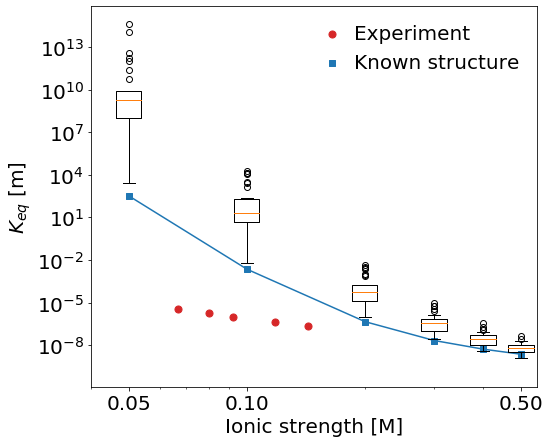

In [89]:
protein = 'adh_pH_7'
dir_destin = mc_keq_dir + 'images/'
my_mk_dir(dir_destin)

fig, ax = plt.subplots()
fig.set_size_inches(8, 7, forward=True)
font = {'weight': 'normal', 'size': 20}
plt.rc('font', **font)
ax.set_xlabel('Ionic strength [M]')
ax.set_ylabel(r'$K_{eq}$ [m]')
ax.set_yscale('log')
ax.set_xscale('log')


# Plot experimental data
df_exp = get_exp_data(protein, resin)
ax.scatter(df_exp['IS(M)'], df_exp['Keq'], marker='o', s=50, label='Experiment',
           color='#d62728')  


# Plot prediction from known structure
integrand_dir = 'ns_bim_monomer_spheres/results/integrand_results/'
Keq_list = []
for ion_str in ion_str_list:
    ion_str_string = str(int(ion_str*1000)) 
    integrand_df_file = resin + '_' + protein + '_' + ion_str_string + '.csv'
    Keq = get_model_Keq_v2([ion_str], integrand_df_file, z0, integrand_dir)[0]
    Keq_list.append(Keq)
    
ax.scatter(ion_str_list, Keq_list, marker='s', label='Known structure')
ax.plot(ion_str_list, Keq_list)


# Plot box and whisker plots
data = []
for ion_str in ion_str_list:
    ion_str_string = str(int(ion_str*1.0e3))
    df_keq = pd.read_csv(mc_keq_dir + ion_str_string + '.csv', index_col=0)
    data.append(list(df_keq['keq_m']))

widths = []
factor = 0.15
for ion_str in ion_str_list:
    widths.append(factor*ion_str)
    
plt.boxplot(data, positions=ion_str_list, widths=widths)



ax.set_xlim(0.04, 0.55)
ax.xaxis.set_major_formatter(NullFormatter())
ax.xaxis.set_minor_formatter(NullFormatter())
ax.set_xticks([0.05, 0.1, 0.5])
ax.get_xaxis().set_major_formatter(ticker.ScalarFormatter())

handles, labels = ax.get_legend_handles_labels()
new_handles = []
for h in handles:
    #only need to edit the errorbar legend entries
    if isinstance(h, container.ErrorbarContainer):
        new_handles.append(h[0])
    else:
        new_handles.append(h)
ax.legend(new_handles, labels, loc='best', frameon=False, handletextpad=0.1)

fig.savefig(dir_destin + 'mc_' + protein + '.png', bbox_inches='tight', dpi = 300)

### Prepare for plotting interesting cases in vmd

In [53]:
base_dir = 'ns_bim_monomer_spheres/ns_bim_programs_pqr_mc/'
proteins = ['adh_pH_7', 'blg_pH_7', 'cat_pH_7']
is_strs  = ['50', '100', '200', '300', '400', '500']

for protein in proteins:
    print('\n', protein)
    keq_res_dir = base_dir + protein + '/mc_keq_results/'
    for is_s in is_strs:
        file = keq_res_dir + is_s + '.csv'
        df   = pd.read_csv(file)
        for i, c in df.iterrows():
            if c['keq_m'] == max(df['keq_m']):
                my_max = i
            if c['keq_m'] == min(df['keq_m']):
                my_min = i
        print(f'max {my_max}, min {my_min}')



 adh_pH_7
max 3, min 7
max 3, min 7
max 14, min 7
max 27, min 10
max 27, min 17
max 27, min 17

 blg_pH_7
max 27, min 21
max 5, min 21
max 5, min 21
max 5, min 21
max 12, min 21
max 12, min 21

 cat_pH_7
max 18, min 24
max 18, min 24
max 23, min 25
max 5, min 24
max 26, min 24
max 26, min 24


In [54]:
iters = [3, 7]
base_dir = 'ns_bim_monomer_spheres/ns_bim_programs_pqr_mc/adh_pH_7/mc_results/50_iteration_'
for i in iters:
    prot_dir = base_dir + str(i) + '/'
    df_link = mono_s.get_link(prot_dir)
    df_node = mono_s.get_nodes(prot_dir)

    save_link_txt(prot_dir, df_link)
    save_node_txt('mab_D', prot_dir, df_node)

In [ ]:
for is_str in protein_folders:
    prot_dir = 'ns_bim_monomer_spheres/results_mab_D/ns_bim_data/' + is_str + '/'
    df_link = mono_s.get_link(prot_dir)
    df_node = mono_s.get_nodes(prot_dir)

    save_link_txt(prot_dir, df_link)
    save_node_txt('mab_D', prot_dir, df_node)

# mAb D - 3 spheres

In [15]:
ion_str_list = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5]

for ion_str in ion_str_list:
    prot_dir     = 'ns_bim_monomer_spheres/ns_bim_program_mab_D/'
    new_folder   = 'ns_bim_monomer_spheres/results_mab_D/ns_bim_data/' +\
                    str(int(ion_str*1.0e3)) + '/'
    meta_run_ns_bim_v2(prot_dir, ion_str, new_folder)

Successfully created the directory ns_bim_monomer_spheres/results_mab_D/ns_bim_data/50/
Successfully created the directory ns_bim_monomer_spheres/results_mab_D/ns_bim_data/100/
Successfully created the directory ns_bim_monomer_spheres/results_mab_D/ns_bim_data/200/
Successfully created the directory ns_bim_monomer_spheres/results_mab_D/ns_bim_data/300/
Successfully created the directory ns_bim_monomer_spheres/results_mab_D/ns_bim_data/400/
Successfully created the directory ns_bim_monomer_spheres/results_mab_D/ns_bim_data/500/


## Run ND model

In [19]:
nsbim_data_dir = 'ns_bim_monomer_spheres/results_mab_D/ns_bim_data/'

protein_folders = os.listdir(nsbim_data_dir)
protein_folders.sort()
protein_folders


['100', '200', '300', '400', '50', '500']

In [20]:
z0 = 3.0e-10 
n = 5000

if n >= 600000:
    epsilon = 214
elif n>= 400000:
    epsilon = 75
elif n>= 11000:
    epsilon = 27
elif n>= 890:
    epsilon = 10
elif n>= 177:
    epsilon = 3.33
elif n>= 24:
    epsilon = 1.33
else:
    epsilon = 0.33

goldenRatio = (1 + 5**0.5)/2
i = np.arange(0, n) 
phi = 2 * np.pi * i / goldenRatio
theta = np.arccos(1 - 2*(i+epsilon)/(n-1+2*epsilon))

In [9]:
integrand_dir  = 'ns_bim_monomer_spheres/results_mab_D/integrand_results/'
resin_list     = ['sep']

for resin in resin_list:
    for name in protein_folders:
        
        ion_str = get_ion_str_from_protein_name(name)
        radius  = 26.83

        prot_dir   = nsbim_data_dir + name
        start_time = time.time()
        sol        = bulk_solution(ion_str)
        protein    = mono_s.protein_class(name)
        protein.df = mono_s.get_df_elem(prot_dir)

        kap_h_min   = 0.1
        kap_h_mid   = 1.2
        kap_h_max   = 9.0
        z_min       = kap_h_min/sol.kappa # [m]
        z_mid       = kap_h_mid/sol.kappa
        z_max       = kap_h_max/sol.kappa
        zs = np.concatenate((np.linspace(z_min, z_mid, 30)[:-1], 
                             np.linspace(z_mid, z_max, 21)))

        energy_map_file = 'oc_energy_maps/' + resin + '_' +\
                          str(int(sol.ion_str*1.0e3)) + '_expanded_1.csv'
        energy_fun      = get_interp_fun(energy_map_file)

        args_list = [(protein, i, theta[i], phi[i], zs, energy_fun, sol, radius) for i in range(n)]
        pool      = mp.Pool(processes = mp.cpu_count())
        results   = pool.map(mono_s.get_integrand_list, args_list)
        pool.close()
        pool.join()

        indeces       = [res[0] for res in results]
        integrand_res = [res[1] for res in results]
        energy_res    = [res[2] for res in results]

        new_integrand_df = pd.DataFrame(integrand_res, index=indeces, columns=zs)

        file = resin + '_' + protein.name + '.csv'
        new_integrand_df.to_csv(integrand_dir + file)

        print_time((time.time() - start_time)/60.0)
        print('Completed ' + file + ' \n')

0.51
Completed sep_100.csv 

0.51
Completed sep_200.csv 

0.50
Completed sep_300.csv 

0.51
Completed sep_400.csv 

0.51
Completed sep_50.csv 

0.51
Completed sep_500.csv 



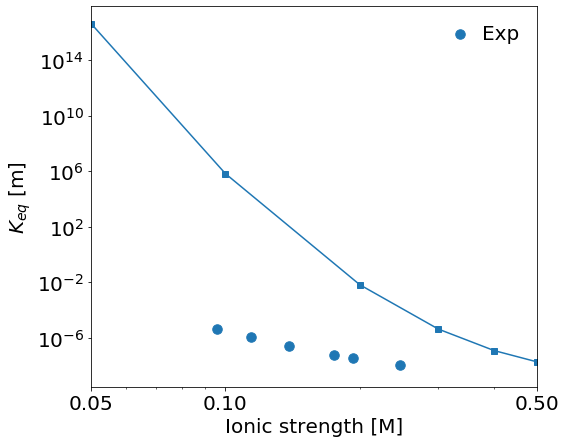

In [25]:
integrand_dir  = 'ns_bim_monomer_spheres/results_mab_D/integrand_results/'
resin_list     = ['sep']
resin = resin_list[0]

fig, ax = plt.subplots()
fig.set_size_inches(8, 7, forward=True)
font = {'weight' : 'normal',
        'size'   : 20}
plt.rc('font', **font)
ax.set_xlabel('Ionic strength [M]')
ax.set_ylabel(r'$K_{eq}$ [m]')
ax.set_yscale('log')
ax.set_xscale('log')
# # axs.set_ylim(7e-9, 1e-5)
# ax.set_ylim(7e-9, 1e-4)
ax.set_xlim(0.05, 0.5)
ax.xaxis.set_major_formatter(NullFormatter())
ax.xaxis.set_minor_formatter(NullFormatter())
ax.set_xticks([0.05, 0.1, 0.5])
ax.get_xaxis().set_major_formatter(ticker.ScalarFormatter())

xs = []
ys = []
for protein in protein_folders:
    xs.append(float(protein)/1e3)
    integrand_df_file = resin + '_' + protein + '.csv'
    Keq = get_model_Keq_v2([ion_str], integrand_df_file, z0, integrand_dir)[0]
    ys.append(Keq)

order = np.argsort(xs)
xs = np.array(xs)[order]
ys = np.array(ys)[order]
ax.plot(xs, ys, 's-')

df_exp = pd.read_csv('experimental_data/mAbD_seph_pH7.csv')
label = 'Exp'
plot_exp_data_v2(ax, df_exp, label)

fig.savefig('ns_bim_monomer_spheres/results_mab_D/images/' + resin + '_' +\
            str(int(round(z0*1.0e12))) + '_pm_z0.png', 
            bbox_inches='tight', dpi = 300)

In [47]:
# For VMD plotting
for is_str in protein_folders:
    prot_dir = 'ns_bim_monomer_spheres/results_mab_D/ns_bim_data/' + is_str + '/'
    df_link = mono_s.get_link(prot_dir)
    df_node = mono_s.get_nodes(prot_dir)

    save_link_txt(prot_dir, df_link)
    save_node_txt('mab_D', prot_dir, df_node)

# One monomer

## Model proteins

In [8]:
ns_bim_dir      = 'ns_bim_programs_one_monomer/'
protein_folders = ['adh_pH_7', 'blg_pH_7', 'cat_pH_7']
ion_str_list    = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5]

for ion_str in ion_str_list:
    for ind, protein in enumerate(protein_folders): 
        prot_dir     = 'ns_bim_monomer_spheres/' + ns_bim_dir + protein + '/'
        new_folder   = 'ns_bim_monomer_spheres/results_one_monomer/ns_bim_data/' + protein + '_' +\
                       str(int(ion_str*1.0e3)) + '/'
        meta_run_ns_bim_v2(prot_dir, ion_str, new_folder)

Creation of the directory ns_bim_monomer_spheres/results_one_monomer/ns_bim_data/adh_pH_7_50/ failed
Creation of the directory ns_bim_monomer_spheres/results_one_monomer/ns_bim_data/blg_pH_7_50/ failed
Creation of the directory ns_bim_monomer_spheres/results_one_monomer/ns_bim_data/cat_pH_7_50/ failed
Creation of the directory ns_bim_monomer_spheres/results_one_monomer/ns_bim_data/adh_pH_7_100/ failed
Creation of the directory ns_bim_monomer_spheres/results_one_monomer/ns_bim_data/blg_pH_7_100/ failed
Creation of the directory ns_bim_monomer_spheres/results_one_monomer/ns_bim_data/cat_pH_7_100/ failed
Creation of the directory ns_bim_monomer_spheres/results_one_monomer/ns_bim_data/adh_pH_7_200/ failed
Creation of the directory ns_bim_monomer_spheres/results_one_monomer/ns_bim_data/blg_pH_7_200/ failed
Creation of the directory ns_bim_monomer_spheres/results_one_monomer/ns_bim_data/cat_pH_7_200/ failed
Creation of the directory ns_bim_monomer_spheres/results_one_monomer/ns_bim_data/adh_

In [9]:
nsbim_data_dir = 'ns_bim_monomer_spheres/results_one_monomer/ns_bim_data/'

protein_folders = os.listdir(nsbim_data_dir)
protein_folders.sort()
protein_folders

['adh_pH_7_100',
 'adh_pH_7_200',
 'adh_pH_7_300',
 'adh_pH_7_400',
 'adh_pH_7_50',
 'adh_pH_7_500',
 'blg_pH_7_100',
 'blg_pH_7_200',
 'blg_pH_7_300',
 'blg_pH_7_400',
 'blg_pH_7_50',
 'blg_pH_7_500',
 'cat_pH_7_100',
 'cat_pH_7_200',
 'cat_pH_7_300',
 'cat_pH_7_400',
 'cat_pH_7_50',
 'cat_pH_7_500']

In [10]:
z0 = 3.0e-10 
n = 5000

if n >= 600000:
    epsilon = 214
elif n>= 400000:
    epsilon = 75
elif n>= 11000:
    epsilon = 27
elif n>= 890:
    epsilon = 10
elif n>= 177:
    epsilon = 3.33
elif n>= 24:
    epsilon = 1.33
else:
    epsilon = 0.33

goldenRatio = (1 + 5**0.5)/2
i = np.arange(0, n) 
phi = 2 * np.pi * i / goldenRatio
theta = np.arccos(1 - 2*(i+epsilon)/(n-1+2*epsilon))

In [11]:
integrand_dir  = 'ns_bim_monomer_spheres/results_one_monomer/integrand_results/'
resin_list     = ['phq', 'pxq', 'caq']

for resin in resin_list:
    for name in protein_folders:
        
        ion_str = get_ion_str_from_protein_name(name)
        radius  = get_monomer_radius(name)
        
        prot_dir   = nsbim_data_dir + name
        start_time = time.time()
        sol        = bulk_solution(ion_str)
        protein    = mono_s.protein_class(name)
        protein.df = mono_s.get_df_elem(prot_dir)

        kap_h_min   = 0.1
        kap_h_mid   = 1.2
        kap_h_max   = 9.0
        z_min       = kap_h_min/sol.kappa # [m]
        z_mid       = kap_h_mid/sol.kappa
        z_max       = kap_h_max/sol.kappa
        zs = np.concatenate((np.linspace(z_min, z_mid, 30)[:-1], 
                             np.linspace(z_mid, z_max, 21)))

        energy_map_file = 'oc_energy_maps/' + resin + '_' +\
                          str(int(sol.ion_str*1.0e3)) + '_expanded_1.csv'
        energy_fun      = get_interp_fun(energy_map_file)

        args_list = [(protein, i, theta[i], phi[i], zs, energy_fun, sol, radius) for i in range(n)]
        pool      = mp.Pool(processes = mp.cpu_count())
        results   = pool.map(mono_s.get_integrand_list, args_list)
        pool.close()
        pool.join()

        indeces       = [res[0] for res in results]
        integrand_res = [res[1] for res in results]
        energy_res    = [res[2] for res in results]

        new_integrand_df = pd.DataFrame(integrand_res, index=indeces, columns=zs)

        file = resin + '_' + protein.name + '.csv'
        new_integrand_df.to_csv(integrand_dir + file)

        print_time((time.time() - start_time)/60.0)
        print('Completed ' + file + ' \n')

0.60
Completed phq_adh_pH_7_100.csv 

0.62
Completed phq_adh_pH_7_200.csv 

0.61
Completed phq_adh_pH_7_300.csv 

0.62
Completed phq_adh_pH_7_400.csv 

0.62
Completed phq_adh_pH_7_50.csv 

0.62
Completed phq_adh_pH_7_500.csv 

0.61
Completed phq_blg_pH_7_100.csv 

0.61
Completed phq_blg_pH_7_200.csv 

0.62
Completed phq_blg_pH_7_300.csv 

0.62
Completed phq_blg_pH_7_400.csv 

0.61
Completed phq_blg_pH_7_50.csv 

0.62
Completed phq_blg_pH_7_500.csv 

0.62
Completed phq_cat_pH_7_100.csv 

0.62
Completed phq_cat_pH_7_200.csv 

0.62
Completed phq_cat_pH_7_300.csv 

0.62
Completed phq_cat_pH_7_400.csv 

0.62
Completed phq_cat_pH_7_50.csv 

0.63
Completed phq_cat_pH_7_500.csv 

0.63
Completed pxq_adh_pH_7_100.csv 

0.63
Completed pxq_adh_pH_7_200.csv 

0.63
Completed pxq_adh_pH_7_300.csv 

0.63
Completed pxq_adh_pH_7_400.csv 

0.62
Completed pxq_adh_pH_7_50.csv 

0.63
Completed pxq_adh_pH_7_500.csv 

0.62
Completed pxq_blg_pH_7_100.csv 

0.62
Completed pxq_blg_pH_7_200.csv 

0.63
Completed p

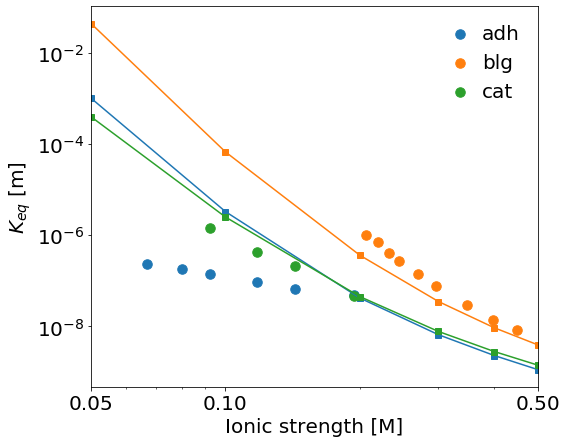

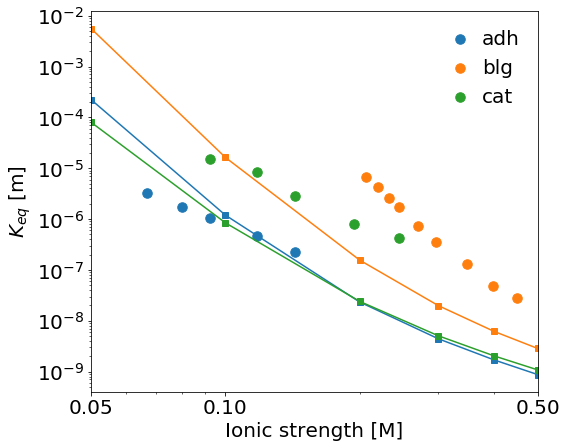

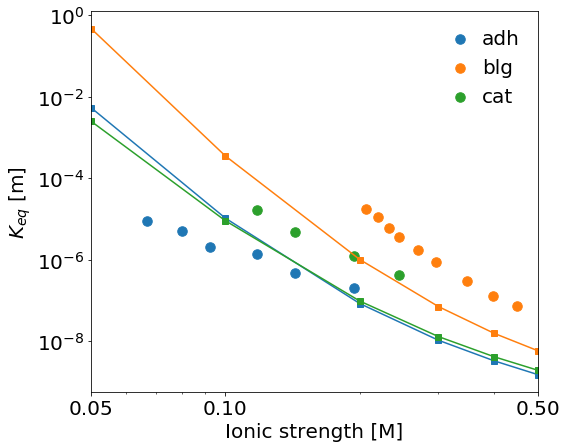

In [13]:
integrand_dir  = 'ns_bim_monomer_spheres/results_one_monomer/integrand_results/'
resin_list     = ['caq', 'phq', 'pxq']

z0 = 3.0e-10 

res = {}
species_pH = {}
for protein in protein_folders:
    species_pH[protein[:protein.rfind('_')]] = 1

for resin in resin_list:
    fig, ax = plt.subplots()
    fig.set_size_inches(8, 7, forward=True)
    font = {'weight' : 'normal',
            'size'   : 20}
    plt.rc('font', **font)
    ax.set_xlabel('Ionic strength [M]')
    ax.set_ylabel(r'$K_{eq}$ [m]')
    ax.set_yscale('log')
    ax.set_xscale('log')
    # # axs.set_ylim(7e-9, 1e-5)
    # ax.set_ylim(7e-9, 1e-4)
    ax.set_xlim(0.05, 0.5)
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.xaxis.set_minor_formatter(NullFormatter())
    ax.set_xticks([0.05, 0.1, 0.5])
    ax.get_xaxis().set_major_formatter(ticker.ScalarFormatter())
    
    for protein in protein_folders:
        if protein[:3] == 'lys':
            pass
        else:
            integrand_df_file = resin + '_' + protein + '.csv'
            Keq = get_model_Keq_v2([ion_str], integrand_df_file, z0, integrand_dir)[0]
            res[protein] = Keq

    for key in species_pH:
        if key[:3] == 'lys':
            pass
        else:
            
            ion_str = []
            Keq = []
            for rkey in res:
                if rkey[:rkey.rfind('_')] == key:
                    ion_str.append(get_ion_str_from_protein_name(rkey))
                    Keq.append(res[rkey])
            order = np.argsort(ion_str)
            xs = np.array(ion_str)[order]
            ys = np.array(Keq)[order]
            ax.plot(xs, ys, 's-')

            df_exp = get_exp_data(key, resin)
            label = key[:3]
            plot_exp_data_v2(ax, df_exp, label)

    fig.savefig('ns_bim_monomer_spheres/results_one_monomer/images/' + resin + '_' +\
                str(int(round(z0*1.0e12))) + '_pm_z0.png', 
                bbox_inches='tight', dpi = 300)

## mAb D

In [8]:
ns_bim_dir      = 'ns_bim_programs_one_monomer_mab_D/'
protein_folders = ['fab_1', 'fab_2', 'fc']
ion_str_list    = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5]

for ion_str in ion_str_list:
    for ind, protein in enumerate(protein_folders): 
        prot_dir     = 'ns_bim_monomer_spheres/' + ns_bim_dir + protein + '/'
        new_folder   = 'ns_bim_monomer_spheres/results_one_monomer_mab_D/ns_bim_data/' + protein + '_' +\
                       str(int(ion_str*1.0e3)) + '/'
        meta_run_ns_bim_v2(prot_dir, ion_str, new_folder)

Successfully created the directory ns_bim_monomer_spheres/results_one_monomer_mab_D/ns_bim_data/fab_1_50/
Successfully created the directory ns_bim_monomer_spheres/results_one_monomer_mab_D/ns_bim_data/fab_2_50/
Successfully created the directory ns_bim_monomer_spheres/results_one_monomer_mab_D/ns_bim_data/fc_50/
Successfully created the directory ns_bim_monomer_spheres/results_one_monomer_mab_D/ns_bim_data/fab_1_100/
Successfully created the directory ns_bim_monomer_spheres/results_one_monomer_mab_D/ns_bim_data/fab_2_100/
Successfully created the directory ns_bim_monomer_spheres/results_one_monomer_mab_D/ns_bim_data/fc_100/
Successfully created the directory ns_bim_monomer_spheres/results_one_monomer_mab_D/ns_bim_data/fab_1_200/
Successfully created the directory ns_bim_monomer_spheres/results_one_monomer_mab_D/ns_bim_data/fab_2_200/
Successfully created the directory ns_bim_monomer_spheres/results_one_monomer_mab_D/ns_bim_data/fc_200/
Successfully created the directory ns_bim_monomer

In [7]:
nsbim_data_dir = 'ns_bim_monomer_spheres/results_one_monomer_mab_D/ns_bim_data/'

protein_folders = os.listdir(nsbim_data_dir)
protein_folders.sort()
protein_folders

['fab_1_100',
 'fab_1_200',
 'fab_1_300',
 'fab_1_400',
 'fab_1_50',
 'fab_1_500',
 'fab_2_100',
 'fab_2_200',
 'fab_2_300',
 'fab_2_400',
 'fab_2_50',
 'fab_2_500',
 'fc_100',
 'fc_200',
 'fc_300',
 'fc_400',
 'fc_50',
 'fc_500']

In [10]:
z0 = 3.0e-10 
n = 5000

if n >= 600000:
    epsilon = 214
elif n>= 400000:
    epsilon = 75
elif n>= 11000:
    epsilon = 27
elif n>= 890:
    epsilon = 10
elif n>= 177:
    epsilon = 3.33
elif n>= 24:
    epsilon = 1.33
else:
    epsilon = 0.33

goldenRatio = (1 + 5**0.5)/2
i = np.arange(0, n) 
phi = 2 * np.pi * i / goldenRatio
theta = np.arccos(1 - 2*(i+epsilon)/(n-1+2*epsilon))

In [11]:
integrand_dir  = 'ns_bim_monomer_spheres/results_one_monomer_mab_D/integrand_results/'
resin_list     = ['sep']

for resin in resin_list:
    for name in protein_folders:
        if name[:5] == 'fab_1':
            pass
        else:
        
            ion_str = get_ion_str_from_protein_name(name)
            radius  = 26.83

            prot_dir   = nsbim_data_dir + name
            start_time = time.time()
            sol        = bulk_solution(ion_str)
            protein    = mono_s.protein_class(name)
            protein.df = mono_s.get_df_elem(prot_dir)

            kap_h_min   = 0.1
            kap_h_mid   = 1.2
            kap_h_max   = 9.0
            z_min       = kap_h_min/sol.kappa # [m]
            z_mid       = kap_h_mid/sol.kappa
            z_max       = kap_h_max/sol.kappa
            zs = np.concatenate((np.linspace(z_min, z_mid, 30)[:-1], 
                                 np.linspace(z_mid, z_max, 21)))

            energy_map_file = 'oc_energy_maps/' + resin + '_' +\
                              str(int(sol.ion_str*1.0e3)) + '_expanded_1.csv'
            energy_fun      = get_interp_fun(energy_map_file)

            args_list = [(protein, i, theta[i], phi[i], zs, energy_fun, sol, radius) for i in range(n)]
            pool      = mp.Pool(processes = mp.cpu_count())
            results   = pool.map(mono_s.get_integrand_list, args_list)
            pool.close()
            pool.join()

            indeces       = [res[0] for res in results]
            integrand_res = [res[1] for res in results]
            energy_res    = [res[2] for res in results]

            new_integrand_df = pd.DataFrame(integrand_res, index=indeces, columns=zs)

            file = resin + '_' + protein.name + '.csv'
            new_integrand_df.to_csv(integrand_dir + file)

            print_time((time.time() - start_time)/60.0)
            print('Completed ' + file + ' \n')

0.59
Completed sep_fab_2_100.csv 

0.60
Completed sep_fab_2_200.csv 

0.61
Completed sep_fab_2_300.csv 

0.61
Completed sep_fab_2_400.csv 

0.62
Completed sep_fab_2_50.csv 

0.62
Completed sep_fab_2_500.csv 

0.62
Completed sep_fc_100.csv 

0.62
Completed sep_fc_200.csv 

0.63
Completed sep_fc_300.csv 

0.63
Completed sep_fc_400.csv 

0.63
Completed sep_fc_50.csv 

0.63
Completed sep_fc_500.csv 



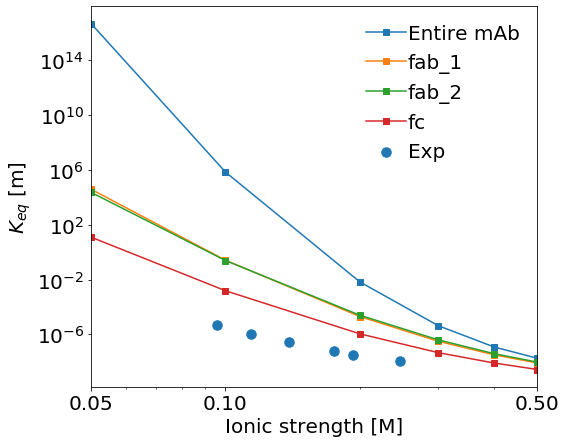

In [18]:
integrand_dir  = 'ns_bim_monomer_spheres/results_one_monomer_mab_D/integrand_results/'
resin = resin_list[0]
z0 = 3.0e-10 

res = {}
species_pH = {}
for protein in protein_folders:
    species_pH[protein[:protein.rfind('_')]] = 1

for resin in resin_list:
    fig, ax = plt.subplots()
    fig.set_size_inches(8, 7, forward=True)
    font = {'weight' : 'normal',
            'size'   : 20}
    plt.rc('font', **font)
    ax.set_xlabel('Ionic strength [M]')
    ax.set_ylabel(r'$K_{eq}$ [m]')
    ax.set_yscale('log')
    ax.set_xscale('log')
    # # axs.set_ylim(7e-9, 1e-5)
    # ax.set_ylim(7e-9, 1e-4)
    ax.set_xlim(0.05, 0.5)
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.xaxis.set_minor_formatter(NullFormatter())
    ax.set_xticks([0.05, 0.1, 0.5])
    ax.get_xaxis().set_major_formatter(ticker.ScalarFormatter())
    
    
    nsbim_data_dir = 'ns_bim_monomer_spheres/results_mab_D/ns_bim_data/'
    protein_folders = os.listdir(nsbim_data_dir)
    protein_folders.sort()

    xs = []
    ys = []
    for protein in protein_folders:
        xs.append(float(protein)/1e3)
        integrand_df_file = resin + '_' + protein + '.csv'
        Keq = get_model_Keq_v2([ion_str], integrand_df_file, z0, 'ns_bim_monomer_spheres/results_mab_D/integrand_results/')[0]
        ys.append(Keq)

    order = np.argsort(xs)
    xs = np.array(xs)[order]
    ys = np.array(ys)[order]
    ax.plot(xs, ys, 's-', label='Entire mAb')
    
    
    
    
    nsbim_data_dir = 'ns_bim_monomer_spheres/results_one_monomer_mab_D/ns_bim_data/'
    protein_folders = os.listdir(nsbim_data_dir)
    protein_folders.sort()
    
    for protein in protein_folders:
        if protein[:3] == 'lys':
            pass
        else:
            integrand_df_file = resin + '_' + protein + '.csv'
            Keq = get_model_Keq_v2([ion_str], integrand_df_file, z0, integrand_dir)[0]
            res[protein] = Keq

    for key in species_pH:
        if key[:3] == 'lys':
            pass
        else:
            
            ion_str = []
            Keq = []
            for rkey in res:
                if rkey[:rkey.rfind('_')] == key:
                    ion_str.append(get_ion_str_from_protein_name(rkey))
                    Keq.append(res[rkey])
            order = np.argsort(ion_str)
            xs = np.array(ion_str)[order]
            ys = np.array(Keq)[order]
            ax.plot(xs, ys, 's-', label=key)
    
    df_exp = pd.read_csv('experimental_data/mAbD_seph_pH7.csv')
    label = 'Exp'
    plot_exp_data_v2(ax, df_exp, label)

    fig.savefig('ns_bim_monomer_spheres/results_one_monomer_mab_D/images/' + protein + '_' + resin + '_' +\
                str(int(round(z0*1.0e12))) + '_pm_z0.png', 
                bbox_inches='tight', dpi = 300)

# Investigation of cluster effect
Compute average boundary element separation distances and integral contributions

In [7]:
results_dir = 'results'
z0          = 3.0e-10 

nsbim_data_dir   = 'ns_bim_monomer_spheres/' + results_dir + '/ns_bim_data/'
integrand_dir    = 'ns_bim_monomer_spheres/' + results_dir + '/integrand_results/'
integral_dir     = 'ns_bim_monomer_spheres/' + results_dir + '/integral_results/'
images_dir       = 'ns_bim_monomer_spheres/' + results_dir + '/images/'

my_mk_dir(integral_dir)

Creation of the directory ns_bim_monomer_spheres/results/integral_results/ failed


In [8]:
base_names = ['adh_pH_7', 'blg_pH_7', 'cat_pH_7']
resins     = ['caq', 'phq', 'pxq']

protein_folders = os.listdir(nsbim_data_dir)
remove_elements = [i for i in protein_folders if 'sep' in i]
for elem in remove_elements:
    protein_folders.remove(elem)
protein_folders.sort()
protein_folders

['adh_pH_7_100',
 'adh_pH_7_200',
 'adh_pH_7_300',
 'adh_pH_7_400',
 'adh_pH_7_50',
 'adh_pH_7_500',
 'blg_pH_7_100',
 'blg_pH_7_200',
 'blg_pH_7_300',
 'blg_pH_7_400',
 'blg_pH_7_50',
 'blg_pH_7_500',
 'cat_pH_7_100',
 'cat_pH_7_200',
 'cat_pH_7_300',
 'cat_pH_7_400',
 'cat_pH_7_50',
 'cat_pH_7_500']

In [10]:
args_list = []
for resin in resins:
    for name in protein_folders:
        args_list.append((nsbim_data_dir, integrand_dir, integral_dir, resin, name, z0))
        
pool      = mp.Pool(processes = mp.cpu_count())
results   = pool.map(mono_s.get_and_save_integral_contribs_2, args_list)
pool.close()
pool.join()

## Look at results

In [30]:
integral_files = os.listdir(integral_dir)
integral_files.sort()
integral_files.reverse()

integral_files

['pxq_cat_pH_7_500.csv',
 'pxq_cat_pH_7_50.csv',
 'pxq_cat_pH_7_400.csv',
 'pxq_cat_pH_7_300.csv',
 'pxq_cat_pH_7_200.csv',
 'pxq_cat_pH_7_100.csv',
 'pxq_blg_pH_7_500.csv',
 'pxq_blg_pH_7_50.csv',
 'pxq_blg_pH_7_400.csv',
 'pxq_blg_pH_7_300.csv',
 'pxq_blg_pH_7_200.csv',
 'pxq_blg_pH_7_100.csv',
 'pxq_adh_pH_7_500.csv',
 'pxq_adh_pH_7_50.csv',
 'pxq_adh_pH_7_400.csv',
 'pxq_adh_pH_7_300.csv',
 'pxq_adh_pH_7_200.csv',
 'pxq_adh_pH_7_100.csv',
 'phq_cat_pH_7_500.csv',
 'phq_cat_pH_7_50.csv',
 'phq_cat_pH_7_400.csv',
 'phq_cat_pH_7_300.csv',
 'phq_cat_pH_7_200.csv',
 'phq_cat_pH_7_100.csv',
 'phq_blg_pH_7_500.csv',
 'phq_blg_pH_7_50.csv',
 'phq_blg_pH_7_400.csv',
 'phq_blg_pH_7_300.csv',
 'phq_blg_pH_7_200.csv',
 'phq_blg_pH_7_100.csv',
 'phq_adh_pH_7_500.csv',
 'phq_adh_pH_7_50.csv',
 'phq_adh_pH_7_400.csv',
 'phq_adh_pH_7_300.csv',
 'phq_adh_pH_7_200.csv',
 'phq_adh_pH_7_100.csv',
 'caq_cat_pH_7_500.csv',
 'caq_cat_pH_7_50.csv',
 'caq_cat_pH_7_400.csv',
 'caq_cat_pH_7_300.csv',
 'caq_c

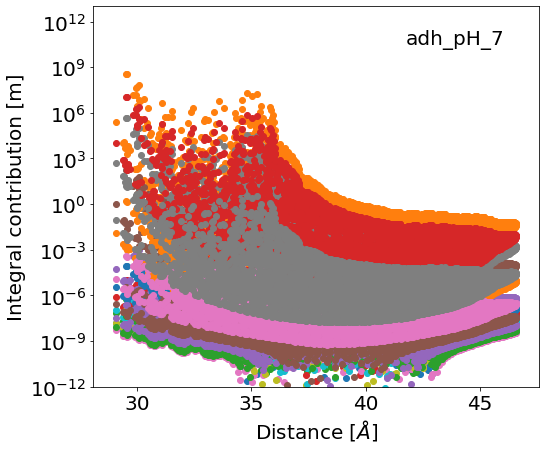

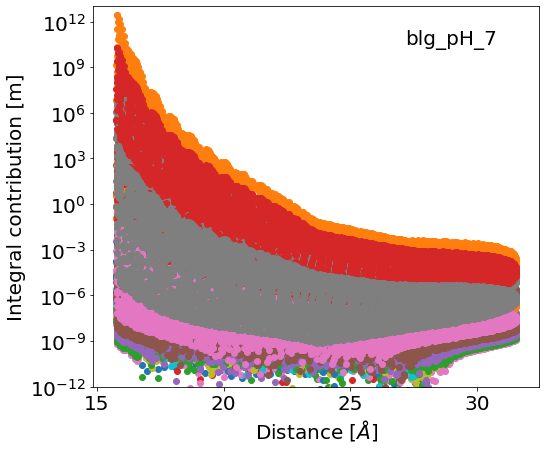

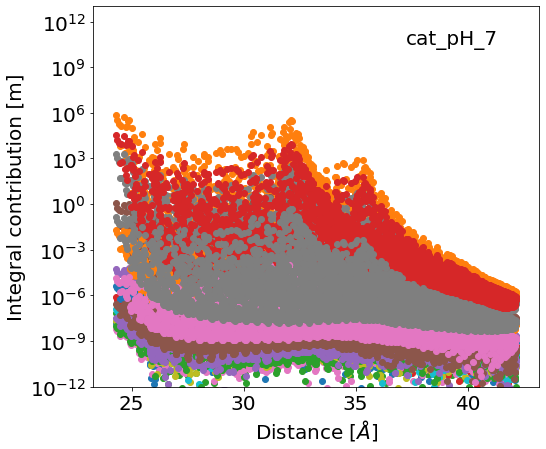

In [31]:
for name in base_names:
    fig, ax = plt.subplots()
    fig.set_size_inches(8, 7, forward=True)
    font = {'weight': 'normal', 'size': 20}
    plt.rc('font', **font)
    ax.set_xlabel(r'Distance [$\AA$]')
    ax.set_ylabel('Integral contribution [m]')
    ax.set_yscale('log')
    ax.set_ylim(1.0e-12, 1.0e13)
    
    for file in integral_files:
        if name in file:
            df = pd.read_csv(integral_dir + file)
            ax.scatter(df['average_distance_A'], df['integral'])
    
    ax.text(0.7, 0.9, name, transform=ax.transAxes)
    fig.savefig(images_dir + name + '.png', bbox_inches='tight', dpi = 300)